In [1]:
%config Completer.use_jedi = False

import sys
sys.path.insert(1,'../contour-integration_models/')
sys.path.insert(1,'../dev/')



# Pytorch related
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils import data as dt
from torchinfo import summary
import torchvision.models as pretrained_models
from alexnet_pytorch import AlexNet
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils import model_zoo
from IPython.html.widgets import interact, interactive, fixed


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



import numpy as np
import pandas as pd
import os
import glob
import json

import scipy.stats as stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.stattools import durbin_watson


# Extra imports
from lib.feature_extractor import FeatureExtractor
from lib.custom_dataset import Contour_Dataset
from lib.build_fe_ft_models import *
from lib.misc_functions import *
from lib.field_stim_functions import *


/opt/conda/lib/python3.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


ModuleNotFoundError: No module named 'lib'

# Signal Strength Analysis [Image-level but can also be done at level of conditions]

### Getting images

In [921]:
img_dim=512
num_workers=8
batch_size=2
device = torch.device('cuda:'+'3')
# device = 'cpu'
device

device(type='cuda', index=3)

In [922]:
# normalize images using parameters from the training image set
data_transform = transforms.Compose([       
 transforms.Resize(img_dim),                   
 transforms.CenterCrop((img_dim,img_dim)),         
 transforms.ToTensor(),                    
 transforms.Normalize(                      
 mean=[0.485, 0.456, 0.406],                
 std=[0.229, 0.224, 0.225]                  
 )])

data_transform_without_norm = transforms.Compose([       
 transforms.Resize(img_dim),                   
 transforms.CenterCrop((img_dim,img_dim)),         
 transforms.ToTensor()                    
 ])

In [923]:
class Psychophysics_Dataset(Dataset):
    
    def __init__(self, root, get_B=[30,60], get_D=[32],get_A=[0], get_numElements=[12], get_contour='all', total_images=None,transform=None):

        if not isinstance(get_B, (list,)):
            get_B = [get_B]
            
            
        if not isinstance(get_D, (list,)):
            get_D = [get_D]
            
            
        if not isinstance(get_A, (list,)):
            get_A = [get_A]
            
        if not isinstance(get_numElements, (list,)):
            get_numElements = [get_numElements]
              
                
        
        self.root = os.path.expanduser(root)
        self.transform = transform
        
        self.df=pd.read_csv(os.path.join(self.root,'psychophysics.csv'))
        
        if(get_contour=='contour'):
            self.conditional_df=self.df.loc[(self.df['B'].isin(get_B)) & (self.df['D'].isin(get_D)) & (self.df['A'].isin(get_A)) & (self.df['numElements'].isin(get_numElements)) & (self.df['c']=='contour')]
        elif(get_contour=='control'):
            self.conditional_df=self.df.loc[(self.df['B'].isin(get_B)) & (self.df['D'].isin(get_D)) & (self.df['A'].isin(get_A)) & (self.df['numElements'].isin(get_numElements)) & (self.df['c']!='contour')]
        else:
            self.conditional_df=self.df.loc[(self.df['B'].isin(get_B)) & (self.df['D'].isin(get_D)) & (self.df['A'].isin(get_A)) & (self.df['numElements'].isin(get_numElements))]
        
        self.img_path=self.conditional_df.img_path
        self.img_B=self.conditional_df.B
        self.img_D=self.conditional_df.D
        self.img_A=self.conditional_df.A
        self.img_numElements=self.conditional_df.numElements
        self.img_contour=self.conditional_df.c
        self.img_recorder_path=self.conditional_df.img_recorder_path
        
        
          
    def __getitem__(self, index):
        
        ## Get the images
        img = Image.open(self.img_path.iloc[index]).convert('RGB')
        if self.transform:
            img = self.transform(img)

    ## get the Labels
        img_B=self.img_B.iloc[index]
        img_D=self.img_D.iloc[index]
        img_A=self.img_A.iloc[index]
        img_numElements=self.img_numElements.iloc[index]
        img_contour = self.img_contour.iloc[index]
        if(img_contour=='contour'):
            img_contour=1
        else:
            img_contour=0
        img_recorder_path=self.img_recorder_path.iloc[index]

        return img, img_B, img_D, img_A, img_numElements, img_contour, img_recorder_path
    
    
    
    def __len__(self):
        '''
        Return the length of the complete dataset
        '''
        return len(self.conditional_df)
    
    def condition_frequency(self,condition):
        print('TOTAL Datapoints: ',len(self.conditional_df))
        if(condition in list(self.conditional_df.columns)):
            for i in set(list(self.conditional_df[condition])):
                print('Condition: ',i,'\t',len(np.where(self.conditional_df[condition]==i)[0]))
        else:
            raise Exception('Condition not in df')

In [924]:
# psychophysics_dataset_norm = Psychophysics_Dataset(root=os.path.expanduser('/home/jovyan/work/Datasets/contour_integration/model-psychophysics/experiment_1/'),transform=data_transform,get_B=[0,15,30,45,60,75],get_D=[32],get_A=[0])
# psychophysics_loader_norm=torch.utils.data.DataLoader(dataset=psychophysics_dataset_norm, batch_size=15, num_workers=num_workers, shuffle=False)
# len(psychophysics_dataset_norm)

# 1) Getting behavior data

In [925]:
def load_variables(filename):
    """
    Load multiple Python variables from a file.
    
    Parameters:
    - filename (str): the name of the file to load from.
    
    Returns:
    - dict: A dictionary containing the loaded variables.
    """
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [926]:
data = load_variables('./contour_exp1/analysis_data/analysis_data.pkl')

In [927]:
all_participants_filename=data['all_participants_filename']
all_participants_correct=data['all_participants_correct']
all_participants_beta=data['all_participants_beta']

In [928]:
all_participants_beta.shape

(78, 200)

### Human Percent Correct

In [929]:
def get_percent_correct(all_participants_filename,all_participants_correct,all_participants_beta):
    unique_images=np.unique(all_participants_filename)

    accuracy_image=[]
    beta_image=[]

    for img in unique_images:
        accuracy_image.append(np.mean(all_participants_correct[np.where(all_participants_filename==img)]))
        beta_image.append(np.mean(all_participants_beta[np.where(all_participants_filename==img)]))
        
    return np.array(accuracy_image),np.array(beta_image),unique_images

In [930]:
human_img_signal,beta_image,unique_images=get_percent_correct(all_participants_filename,all_participants_correct,all_participants_beta)

In [931]:
# unique_images

In [932]:
human_img_signal.shape

(1000,)

### Human Beta-wise Accuracy

In [933]:
all_participants_beta.shape

(78, 200)

In [934]:
np.unique(all_participants_beta)

array([15, 30, 45, 60, 75])

In [935]:
np.mean(all_participants_correct[np.where(all_participants_beta==75)])

0.4592948717948718

In [936]:
np.std(all_participants_correct[np.where(all_participants_beta==75)])

0.49834033806004924

In [937]:
all_participants_unique_beta={}
human_unique_beta_acc=[]
for b in np.unique(all_participants_beta):
    all_participants_unique_beta[b]={}
    all_participants_unique_beta[b]['mean']=np.mean(all_participants_correct[np.where(all_participants_beta==b)])
    all_participants_unique_beta[b]['std']=np.std(all_participants_correct[np.where(all_participants_beta==b)])
    human_unique_beta_acc.append([np.mean(all_participants_correct[np.where(all_participants_beta==b)]),np.std(all_participants_correct[np.where(all_participants_beta==b)])])
human_unique_beta_acc=np.array(human_unique_beta_acc)

In [938]:
all_participants_unique_beta

{15: {'mean': 0.9365384615384615, 'std': 0.24379124594134455},
 30: {'mean': 0.8567307692307692, 'std': 0.35034719676918163},
 45: {'mean': 0.6506410256410257, 'std': 0.47676753391335264},
 60: {'mean': 0.49775641025641026, 'std': 0.4999949662797241},
 75: {'mean': 0.4592948717948718, 'std': 0.49834033806004924}}

In [939]:
human_unique_beta_acc

array([[0.93653846, 0.24379125],
       [0.85673077, 0.3503472 ],
       [0.65064103, 0.47676753],
       [0.49775641, 0.49999497],
       [0.45929487, 0.49834034]])

# 2) Loading model

In [1246]:
# sup_regular_finetune_files = glob.glob("../dev/new_ccn23/alexnet_regimagenet_categ_frozen_broad/*.pt")
# sup_regular_finetune_files = glob.glob("../dev/new_ccn23/alexnet_regimagenet_categ_frozen_broad/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_frozen.pt")

# sup_regular_finetune_files = glob.glob("../dev/new_ccn23/alexnet_regimagenet_categ_frozen_narrow/*.pt")






# Imagenet Finetune Broad
sup_regular_finetune_files = glob.glob("../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/*.pt")
# sup_regular_finetune_files = glob.glob("../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune.pt")




# Imagenet Finetune Narrow
# sup_regular_finetune_files = glob.glob("../dev/new_ccn23/alexnet_regimagenet_categ_finetune_narrow/*.pt")







# Imagenet Frozen Narrow
# sup_regular_finetune_files = glob.glob("../dev/new_ccn23/alexnet_regimagenet_categ_frozen_narrow/*.pt")

# Imagenet Frozen Broad
# sup_regular_finetune_files = glob.glob("../dev/new_ccn23/alexnet_regimagenet_categ_frozen_broad/*.pt")





# Barlow Twins Frozen Narrow
# sup_regular_finetune_files = glob.glob("../dev/new_ccn23/alexnet-barlow-regim-barlow_frozen_narrow/*.pt")

# Barlow Twins Frozen Broad
# sup_regular_finetune_files = glob.glob("../dev/new_ccn23/alexnet-barlow-regim-barlow_frozen_broad/*.pt")




## varying_ITM_largeRF
# sup_regular_finetune_files = glob.glob("../dev/new_ccn23/varying_ITM_largeRF/*.pt")


## last fig 6
# sup_regular_finetune_files = glob.glob("../dev/new_ccn23/last_fig_6/*.pt")




In [1247]:
sup_regular_finetune_files=sorted(sup_regular_finetune_files)

In [1248]:
for i,file in enumerate(sup_regular_finetune_files):
    print(i,file)

0 ../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune.pt
1 ../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_classifier-0_mode_finetune.pt
2 ../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_classifier-1_mode_finetune.pt
3 ../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_classifier-2_mode_finetune.pt
4 ../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_classifier-3_mode_finetune.pt
5 ../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_classifier-4_mode_finetune.pt
6 ../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_classifier-5_mode_finetune.pt
7 ../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_l

In [1259]:
file=sup_regular_finetune_files[14]
print(file)

../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/model_alexnet-pytorch-regim-categ_layer_features-3_mode_finetune.pt


In [1260]:
checkpoint=torch.load(file)
loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device=device)
loaded_spliced_model.load_state_dict(checkpoint['model_state_dict'],strict=False)

_IncompatibleKeys(missing_keys=['base_model.features.6.weight', 'base_model.features.6.bias', 'base_model.features.8.weight', 'base_model.features.8.bias', 'base_model.features.10.weight', 'base_model.features.10.bias', 'base_model.classifier.1.weight', 'base_model.classifier.1.bias', 'base_model.classifier.4.weight', 'base_model.classifier.4.bias', 'base_model.classifier.6.weight', 'base_model.classifier.6.bias'], unexpected_keys=[])

In [1261]:
# plt.plot(np.arange(len(checkpoint['metrics']['train_acc'])),checkpoint['metrics']['train_acc'],label='train')
# plt.plot(np.arange(len(checkpoint['metrics']['val_acc'])),checkpoint['metrics']['val_acc'],label='val')    
# plt.legend()

In [1262]:
checkpoint['visual_diet_config']

{'root_directory': '/home/jovyan/work/Datasets/contour_integration/model-training/config_0/',
 'get_B': [0, 15, 30, 45, 60, 75],
 'get_D': [32],
 'get_A': [0],
 'get_numElements': [12]}

In [1263]:
checkpoint['metrics']['val_acc'][-1]

0.5966666666666667

# 3) Model Psychophysics: Computing Signal Strength - 2 systematically controlled images (contours and controls) and 1 output node (contour present) - useful to compare percent correct in a contour in display 1 or 2 task i.e,. 2IFC

In [1203]:
softmax_layer=nn.Softmax(dim=1)

In [1204]:
contour_present=None
contour_absent=None

### When contour is present

In [1205]:
psychophysics_dataset_norm = Psychophysics_Dataset(root=os.path.expanduser('/home/jovyan/work/Datasets/contour_integration/model-psychophysics/experiment_1/'),transform=data_transform,get_B=[0,15,30,45,60,75],get_D=[32],get_A=[0],get_contour='contour')
psychophysics_loader_norm=torch.utils.data.DataLoader(dataset=psychophysics_dataset_norm, batch_size=15, num_workers=num_workers, shuffle=False)



In [1206]:
all_betas=[]
all_labels=[]
all_outputs=[]
all_preds=[]
all_recorder_path=[]


for (inputs, b, d, a, nel, labels, record) in tqdm(psychophysics_loader_norm):
    inputs=inputs.to(device)
    output=loaded_spliced_model.forward(inputs).detach().cpu()
    _, preds = torch.max(output, 1)
        
    all_preds.append(preds)
    
    all_outputs.append(output)
    all_betas.append(b)
    all_labels.append(labels)
    all_recorder_path.append(np.array(record))

  0%|          | 0/67 [00:00<?, ?it/s]

In [1207]:
all_betas=torch.cat(all_betas).numpy()
all_labels=torch.cat(all_labels).numpy()
all_preds=torch.cat(all_preds).numpy()
all_outputs=torch.cat(all_outputs).numpy()
all_recorder_path=np.concatenate(all_recorder_path)

In [1208]:
all_betas.shape

(1000,)

In [1209]:
all_recorder_path.shape

(1000,)

In [1210]:
contour_present=all_outputs

### When contour is absent

In [1211]:
psychophysics_dataset_norm = Psychophysics_Dataset(root=os.path.expanduser('/home/jovyan/work/Datasets/contour_integration/model-psychophysics/experiment_1/'),transform=data_transform,get_B=[0,15,30,45,60,75],get_D=[32],get_A=[0],get_contour='control')
psychophysics_loader_norm=torch.utils.data.DataLoader(dataset=psychophysics_dataset_norm, batch_size=15, num_workers=num_workers, shuffle=False)



In [1212]:
all_betas=[]
all_labels=[]
all_outputs=[]
all_preds=[]
all_recorder_path=[]


for (inputs, b, d, a, nel, labels, record) in tqdm(psychophysics_loader_norm):
    inputs=inputs.to(device)
    output=loaded_spliced_model.forward(inputs).detach().cpu()
    _, preds = torch.max(output, 1)
        
    all_preds.append(preds)
    
    # all_outputs.append(softmax_layer(output))
    all_outputs.append(output)
    
    all_betas.append(b)
    all_labels.append(labels)
    all_recorder_path.append(np.array(record))

  0%|          | 0/67 [00:00<?, ?it/s]

In [1213]:
all_betas=torch.cat(all_betas).numpy()
all_labels=torch.cat(all_labels).numpy()
all_preds=torch.cat(all_preds).numpy()
all_outputs=torch.cat(all_outputs).numpy()
all_recorder_path=np.concatenate(all_recorder_path)

In [1214]:
all_betas.shape

(1000,)

In [1215]:
all_recorder_path.shape

(1000,)

In [1216]:
contour_absent=all_outputs

Text(0.5, 1.0, 'Signal in Trial')

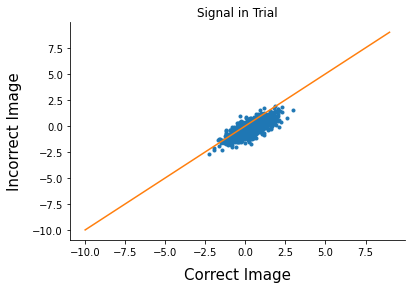

In [1217]:
plt.plot(contour_present[:,1],contour_absent[:,1],'.')
plt.plot(np.arange(-10,10),np.arange(-10,10))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.xlabel('Correct Image',fontsize=15,labelpad=10)
plt.ylabel('Incorrect Image',fontsize=15,labelpad=10)
plt.title('Signal in Trial')

Text(0.5, 1.0, 'Signal in Trial')

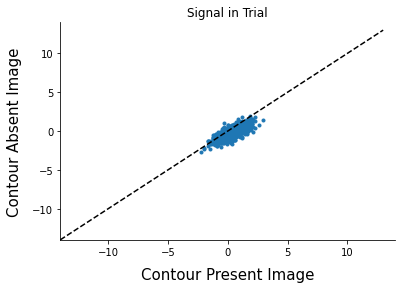

In [1218]:
plt.plot(contour_present[:,1],contour_absent[:,1],'.')
plt.plot(np.arange(-14,14),np.arange(-14,14),linestyle='--',color='k')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.xlabel('Contour Present Image',fontsize=15,labelpad=10)
plt.ylabel('Contour Absent Image',fontsize=15,labelpad=10)

plt.ylim(-14,14)
plt.xlim(-14,14)

plt.title('Signal in Trial')

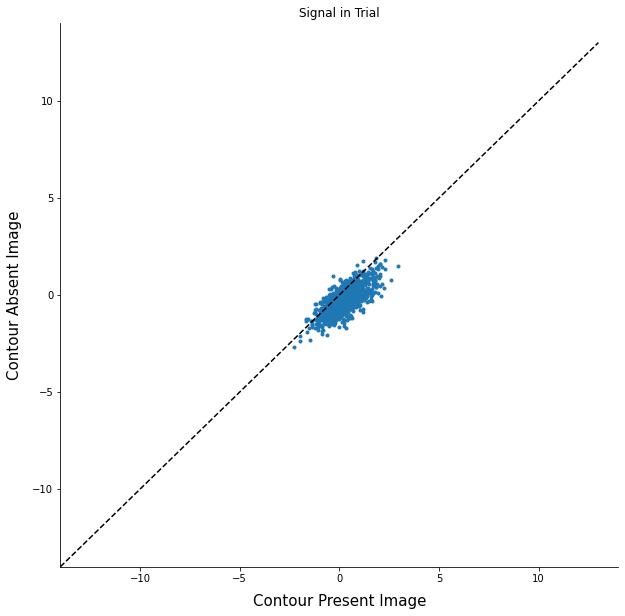

In [1219]:
plt.figure(figsize=(10,10))
plt.plot(contour_present[:,1],contour_absent[:,1],'.')
plt.plot(np.arange(-14,14),np.arange(-14,14),linestyle='--',color='k')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.xlabel('Contour Present Image',fontsize=15,labelpad=10)
plt.ylabel('Contour Absent Image',fontsize=15,labelpad=10)

plt.ylim(-14,14)
plt.xlim(-14,14)



plt.title('Signal in Trial')
plt.savefig('./contour_exp1/plots/model_e1_activations.png',bbox_inches='tight',dpi=600)
plt.show()



In [1220]:
model_img_signal=((contour_present - contour_absent)/np.sqrt(2))[:,1]

In [1221]:
# np.mean(contour_present[:,1] > contour_absent[:,1])
# np.mean(all_participants_correct)

# 4) Comparing model and human signal

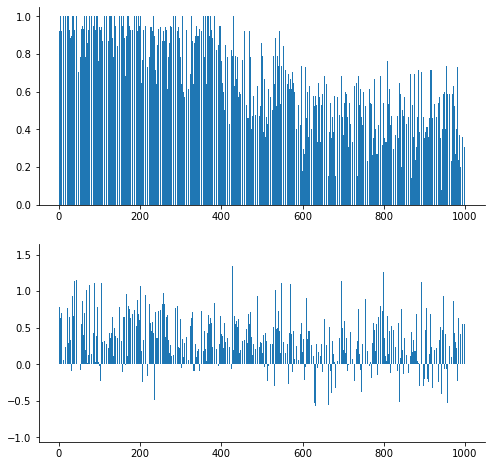

In [1222]:
plt.figure(figsize=(8,8))

plt.subplot(2,1,1)
plt.bar(range(len(human_img_signal)), human_img_signal)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.subplot(2,1,2)
plt.bar(range(len(model_img_signal)), model_img_signal)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

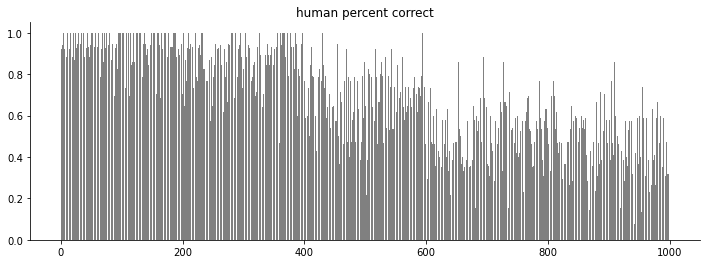

In [1223]:
plt.figure(figsize=(12,4))
plt.bar(range(len(human_img_signal)), human_img_signal,color='gray')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.title('human percent correct')
plt.savefig('./contour_exp1/plots/model_e1_humanpercentcorrect.png',bbox_inches='tight',dpi=600)

plt.show()

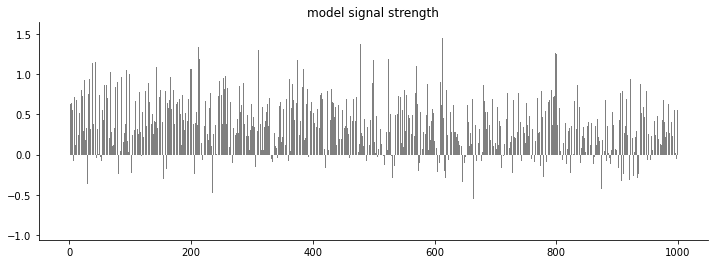

In [1224]:
plt.figure(figsize=(12,4))
plt.bar(range(len(model_img_signal)), model_img_signal,color='gray')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.title('model signal strength')
plt.savefig('./contour_exp1/plots/model_e1_modelsignal.png',bbox_inches='tight',dpi=600)
plt.show()

In [1225]:
np.corrcoef(model_img_signal,human_img_signal)

array([[1.        , 0.27736727],
       [0.27736727, 1.        ]])

In [1226]:
# Example vectors
vector_a = model_img_signal
vector_b = human_img_signal

# Calculate Pearson's r
pearson_r, pearson_p_value = stats.pearsonr(vector_a, vector_b)

# Calculate Spearman's rho
spearman_rho, spearman_p_value = stats.spearmanr(vector_a, vector_b)

# Calculate MSE and RMSE
mse = mean_squared_error(vector_a, vector_b)
rmse = np.sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(vector_a, vector_b)

# Perform Linear Regression
slope, intercept, r_value, p_value, std_err = stats.linregress(vector_a, vector_b)

# Calculating R-squared
r_squared = r_value**2


# To calculate the confidence interval for Pearson's correlation coefficient
def pearson_confidence(r, n, alpha=0.05):
    """
    Calculate the confidence interval for Pearson's correlation coefficient.
    
    Args:
    r: The correlation coefficient.
    n: The number of observations.
    alpha: The significance level (default is 0.05 for a 95% confidence interval).
    
    Returns:
    A tuple containing the lower and upper bounds of the confidence interval.
    """
    # Fisher's z transformation
    z = np.arctanh(r)
    # Standard error
    se = 1 / np.sqrt(n - 3)
    # z critical value
    z_crit = stats.norm.ppf(1 - alpha/2)
    # Margin of error
    moe = z_crit * se
    # Calculate the confidence interval using the inverse Fisher transformation
    z_lower = z - moe
    z_upper = z + moe
    r_lower = np.tanh(z_lower)
    r_upper = np.tanh(z_upper)
    return (r_lower, r_upper)

# Calculate the confidence interval for Pearson's r
pearson_confidence_interval = pearson_confidence(pearson_r, len(vector_a))


# Results
results = {
    'pearson_r': pearson_r,
    'pearson_p_value': pearson_p_value,
    'pearson_confidence_val': pearson_confidence_interval,
    'spearman_rho': spearman_rho,
    'spearman_p_value': spearman_p_value,
    'mse': mse,
    'rmse': rmse,
    'mae': mae,
    'slope': slope,
    'intercept': intercept,
    'r_squared': r_squared,
    'regression_p_value': p_value
}

results

{'pearson_r': 0.27736727151312557,
 'pearson_p_value': 4.0329220916616435e-19,
 'pearson_confidence_val': (0.21914230862459425, 0.33362374306358344),
 'spearman_rho': 0.2854574465179688,
 'spearman_p_value': 3.3248727076371047e-20,
 'mse': 0.24238746277329198,
 'rmse': 0.49232861258847427,
 'mae': 0.4061124753926756,
 'slope': 0.17868653067493312,
 'intercept': 0.6153681553962181,
 'r_squared': 0.07693260330663601,
 'regression_p_value': 4.032922091661283e-19}

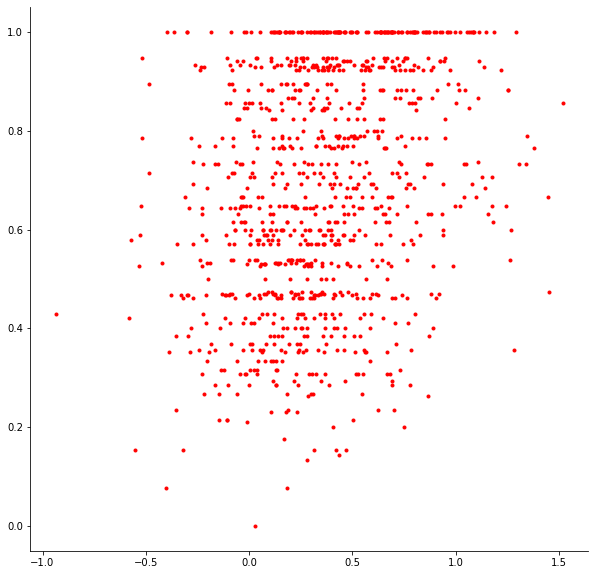

In [1227]:
plt.figure(figsize=(10,10))
plt.plot(model_img_signal,human_img_signal,'.',color='red')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig('./contour_exp1/plots/model_e1_human-model-corr.png',bbox_inches='tight',dpi=600)
plt.show()

In [1228]:
len(all_recorder_path)

1000

In [1229]:
print(np.argmax(model_img_signal),np.max(model_img_signal))

318 1.5190603


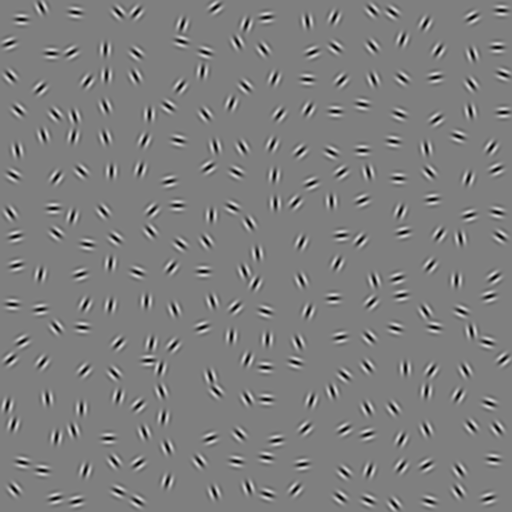

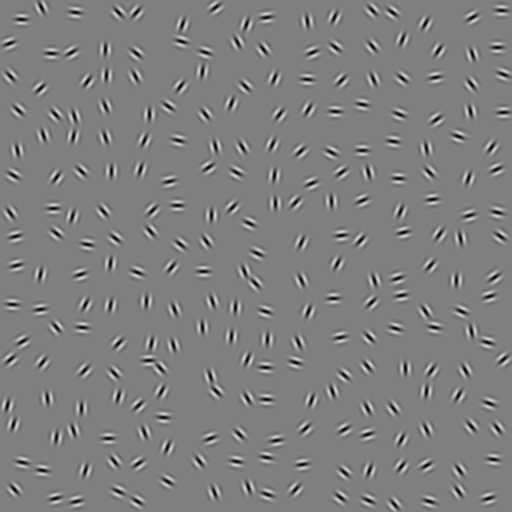

In [1230]:
image_recorder_dict=torch.load(all_recorder_path[np.argmax(model_img_signal)])
img_contour, img_control, img_contour_background, img_control_background=image_renderer(image_recorder_dict)

display(img_contour_background)
display(img_control_background)


In [1231]:
# plt.figure(figsize=(10,10))
# plt.scatter(model_img_signal,human_img_signal,c=all_betas,cmap='cividis')
# plt.show()


In [1232]:
# plt.figure(figsize=(5,4))
# sns.regplot(model_img_signal,human_img_signal,color='g')
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)

# plt.ylabel('Human Percent Correct',fontsize=25,labelpad=20)
# plt.xlabel('Model Signal Strength',fontsize=25,labelpad=20)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)



# plt.savefig('./contour_exp1/plots/narrow_model_human_corr.png', format='png', dpi=600,bbox_inches='tight')
# plt.show()


### Steigler Z-Test

In [1233]:
# # Example vectors
# np.random.seed(0)  # For reproducible results

# # Calculate Pearson correlations
# correlation_ab, _ = stats.pearsonr(human_img_signal, model_img_signal)
# # correlation_ac, _ = stats.pearsonr(human_img_signal, model_img_signal)

# # Steiger's Z test for comparing correlations
# def steigers_z_test(r1, r2, n, two_tailed=True):
#     """
#     Steiger's Z test for comparing two dependent correlations.
    
#     Args:
#     r1, r2: The two correlation coefficients.
#     n: Sample size.
#     two_tailed: If True, perform a two-tailed test.

#     Returns:
#     Z-score and p-value
#     """
#     # Fisher r-to-z transformation
#     z1 = np.arctanh(r1)
#     z2 = np.arctanh(r2)

#     # Standard error
#     se = np.sqrt(1 / (n - 3))

#     # Z-score
#     z = (z1 - z2) / np.sqrt(2 * se**2)

#     # P-value
#     if two_tailed:
#         p = 2 * (1 - stats.norm.cdf(np.abs(z)))
#     else:
#         p = 1 - stats.norm.cdf(np.abs(z))

#     return z, p

# z_score, p_value = steigers_z_test(correlation_ab, correlation_ac, len(vector_a))

# # Display the results
# correlation_ab, correlation_ac, z_score, p_value


# # Display the results
# correlation_ab, correlation_ac, z_score, p_value

# 5) Beta-level accuracy for selected model - Pyschophysics dataset

In [1234]:
psychophysics_dataset_norm = Psychophysics_Dataset(root=os.path.expanduser('/home/jovyan/work/Datasets/contour_integration/model-psychophysics/experiment_1/'),transform=data_transform,get_B=[0,15,30,45,60,75],get_D=[32],get_A=[0],get_contour='all')
psychophysics_loader_norm=torch.utils.data.DataLoader(dataset=psychophysics_dataset_norm, batch_size=15, num_workers=num_workers, shuffle=False)



all_betas=[]
all_labels=[]
all_outputs=[]
all_preds=[]
all_recorder_path=[]


for (inputs, b, d, a, nel, labels, record) in tqdm(psychophysics_loader_norm):
    inputs=inputs.to(device)
    output=loaded_spliced_model.forward(inputs).detach().cpu()
    _, preds = torch.max(output, 1)
        
    all_preds.append(preds)
    
    all_outputs.append(output)
    all_betas.append(b)
    all_labels.append(labels)
    all_recorder_path.append(np.array(record))

all_betas=torch.cat(all_betas).numpy()
all_labels=torch.cat(all_labels).numpy()
all_preds=torch.cat(all_preds).numpy()
all_outputs=torch.cat(all_outputs).numpy()
all_recorder_path=np.concatenate(all_recorder_path)

unique_beta_vals=np.unique(all_betas)
model_unique_beta_acc=[]


for i in unique_beta_vals:
    
    acc=np.mean(all_labels[np.where(all_betas==i)[0]] == all_preds[np.where(all_betas==i)[0]])
    model_unique_beta_acc.append(acc)


  0%|          | 0/134 [00:00<?, ?it/s]

In [1235]:
print(model_unique_beta_acc)
print(human_unique_beta_acc)

[0.695, 0.66, 0.645, 0.62, 0.59]
[[0.93653846 0.24379125]
 [0.85673077 0.3503472 ]
 [0.65064103 0.47676753]
 [0.49775641 0.49999497]
 [0.45929487 0.49834034]]


In [1236]:
model_unique_beta_acc

[0.695, 0.66, 0.645, 0.62, 0.59]

## Setting values and plotting - **PUB**

In [1237]:
narrow_unique_beta_acc=[0.975, 0.93, 0.7275, 0.5125, 0.4975]

broad_unique_beta_acc=[0.9175, 0.9075, 0.935, 0.905, 0.86]

### Human + Explored model

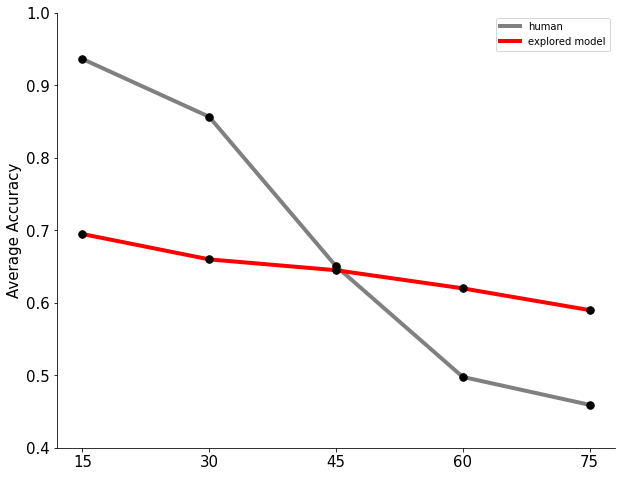

In [1238]:
plt.figure(figsize=(10,8))



plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],color='gray',linewidth=4,label='human')
plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],'.',color='k',markersize=15)

plt.plot(unique_beta_vals,model_unique_beta_acc,linewidth=4,label='explored model',color='r')
plt.plot(unique_beta_vals,model_unique_beta_acc,'.',color='k',markersize=15)








plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)



plt.xticks(unique_beta_vals,fontsize=15)
plt.yticks(fontsize=15) 

plt.ylabel('Average Accuracy',fontsize=15)

plt.ylim(0.4,1.0)
plt.legend()
# plt.savefig('./dev/mauscript_figures/human-e1_broadmodel_beta-acc.png', format='png', dpi=600,bbox_inches='tight')
# plt.savefig('./dev/mauscript_figures/human-e1_narrowmodel_beta-acc.png', format='png', dpi=600,bbox_inches='tight')
plt.show()

### Human + Explored model + Finetuned Narrow + Finetuned Broad

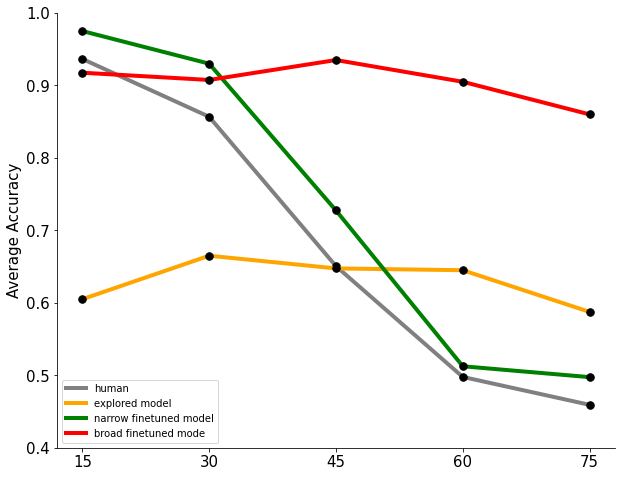

In [986]:
plt.figure(figsize=(10,8))



plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],color='gray',linewidth=4,label='human')
plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],'.',color='k',markersize=15)





plt.plot(unique_beta_vals,model_unique_beta_acc,linewidth=4,label='explored model',color='orange')
plt.plot(unique_beta_vals,model_unique_beta_acc,'.',color='k',markersize=15)


plt.plot(unique_beta_vals,narrow_unique_beta_acc,linewidth=4,label='narrow finetuned model',color='g')
plt.plot(unique_beta_vals,narrow_unique_beta_acc,'.',color='k',markersize=15)

plt.plot(unique_beta_vals,broad_unique_beta_acc,linewidth=4,label='broad finetuned mode',color='r')
plt.plot(unique_beta_vals,broad_unique_beta_acc,'.',color='k',markersize=15)






plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)



plt.xticks(unique_beta_vals,fontsize=15)
plt.yticks(fontsize=15) 

plt.ylabel('Average Accuracy',fontsize=15)

plt.ylim(0.4,1.0)
plt.legend()
# plt.savefig('./dev/mauscript_figures/human-e1_broadmodel_beta-acc.png', format='png', dpi=600,bbox_inches='tight')
# plt.savefig('./dev/mauscript_figures/human-e1_narrowmodel_beta-acc.png', format='png', dpi=600,bbox_inches='tight')
plt.show()

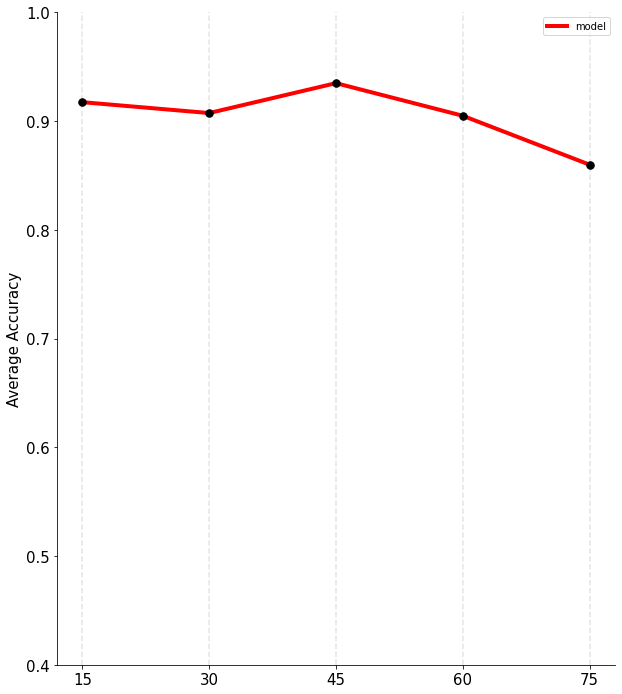

In [987]:
plt.figure(figsize=(10,12))


plt.plot(np.arange(len(unique_beta_vals)),broad_unique_beta_acc,linewidth=4,label='model',color='r')
plt.plot(np.arange(len(unique_beta_vals)),broad_unique_beta_acc,'.',color='k',markersize=15)



plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


for i in range(len(unique_beta_vals)):
    plt.axvline(i,linestyle='--',alpha=0.1,color='k')


plt.xticks(np.arange(len(unique_beta_vals)),unique_beta_vals,fontsize=15)
plt.yticks(fontsize=15) 

plt.ylabel('Average Accuracy',fontsize=15)

plt.ylim(0.4,1.0)
plt.legend()

# plt.savefig('./dev/mauscript_figures/broadmodel_beta-acc.png', format='png', dpi=600,bbox_inches='tight')
plt.show()

### Plotting for barlow model and Random model

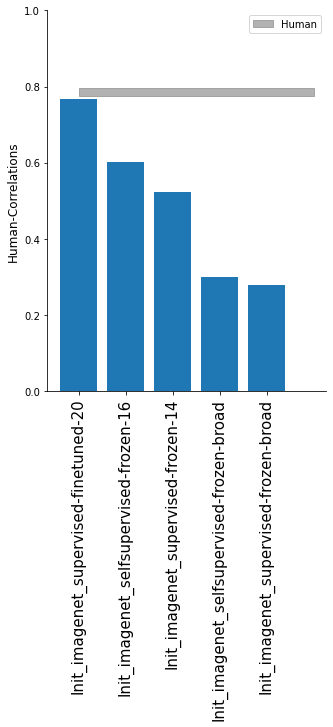

In [66]:
model_11_17_33_31_195_baseline=[0.768, 0.6008245934449947, 0.5221077741641216, 0.3000461960476863,0.27736727151312573]


models = ['Init_imagenet_supervised-finetuned-20','Init_imagenet_selfsupervised-frozen-16', 'Init_imagenet_supervised-frozen-14','Init_imagenet_selfsupervised-frozen-broad','Init_imagenet_supervised-frozen-broad']

# Plot bar chart
fig, ax = plt.subplots(figsize=(5,7))
bars = plt.bar(models, model_11_17_33_31_195_baseline)

plt.fill_between(np.linspace(0,5,100),0.7856633080741112 - 0.009460643283334128, 0.7856633080741112 + 0.009460643283334128,color='gray',alpha=0.6,label='Human')

# Add labels and title

plt.ylabel('Human-Correlations', fontsize=12)

# Set the limit for y-axis (if needed)
plt.xticks(fontsize=15,rotation=90)
plt.ylim(0.0, 1.0)  # Adjust the upper limit to your highest value + some margin

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend()

# Show plot
plt.show()


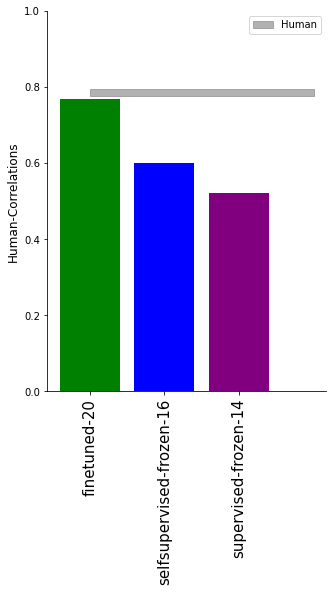

In [550]:
model_11_17_33_31_195_baseline=[0.768, 0.6008245934449947, 0.5221077741641216]


models = ['finetuned-20','selfsupervised-frozen-16', 'supervised-frozen-14']

# Plot bar chart
fig, ax = plt.subplots(figsize=(5,7))
bars = plt.bar(models, model_11_17_33_31_195_baseline,color=['g','b','purple'])

plt.fill_between(np.linspace(0,3,100),0.7856633080741112 - 0.009460643283334128, 0.7856633080741112 + 0.009460643283334128,color='gray',alpha=0.6,label='Human')

# Add labels and title

plt.ylabel('Human-Correlations', fontsize=12)

# Set the limit for y-axis (if needed)
plt.xticks(fontsize=15,rotation=90)
plt.ylim(0.0, 1.0)  # Adjust the upper limit to your highest value + some margin

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend()

# Show plot
plt.show()


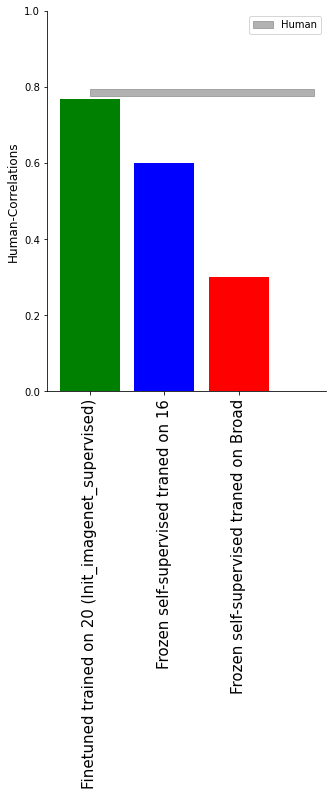

In [104]:
model_11_17_33_31_195_baseline=[0.768, 0.6008245934449947, 0.3000461960476863]


models = ['Finetuned trained on 20 (Init_imagenet_supervised)','Frozen self-supervised traned on 16','Frozen self-supervised traned on Broad']

# Plot bar chart
fig, ax = plt.subplots(figsize=(5,7))
bars = plt.bar(models, model_11_17_33_31_195_baseline,color=['g','b','r'])

plt.fill_between(np.linspace(0,3,100),0.7856633080741112 - 0.009460643283334128, 0.7856633080741112 + 0.009460643283334128,color='gray',alpha=0.6,label='Human')

# Add labels and title

plt.ylabel('Human-Correlations', fontsize=12)

# Set the limit for y-axis (if needed)
plt.xticks(fontsize=15,rotation=90)
plt.ylim(0.0, 1.0)  # Adjust the upper limit to your highest value + some margin

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend()

# Show plot
plt.show()


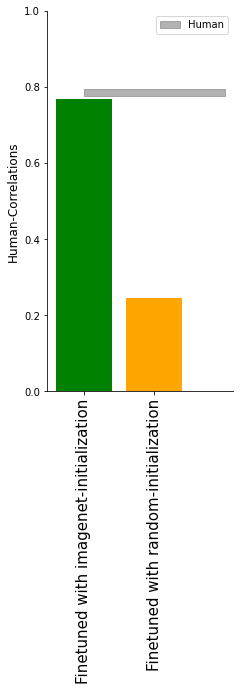

In [107]:
model_11_17_33_31_195_baseline=[0.768, 0.2450965546540889]


models = ['Finetuned with imagenet-initialization','Finetuned with random-initialization']

# Plot bar chart
fig, ax = plt.subplots(figsize=((2*5.0/3),7))
bars = plt.bar(models, model_11_17_33_31_195_baseline,color=['g','orange'])

plt.fill_between(np.linspace(0,2,100),0.7856633080741112 - 0.009460643283334128, 0.7856633080741112 + 0.009460643283334128,color='gray',alpha=0.6,label='Human')

# Add labels and title

plt.ylabel('Human-Correlations', fontsize=12)

# Set the limit for y-axis (if needed)
plt.xticks(fontsize=15,rotation=90)
plt.ylim(0.0, 1.0)  # Adjust the upper limit to your highest value + some margin

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend()

# Show plot
plt.show()


In [380]:
# beta_acc_barlow_frozen_narrow16 = model_unique_beta_acc

In [594]:
# beta_acc_supervised_frozen_narrow14 = model_unique_beta_acc

In [425]:
# beta_acc_barlow_frozen_broad = model_unique_beta_acc

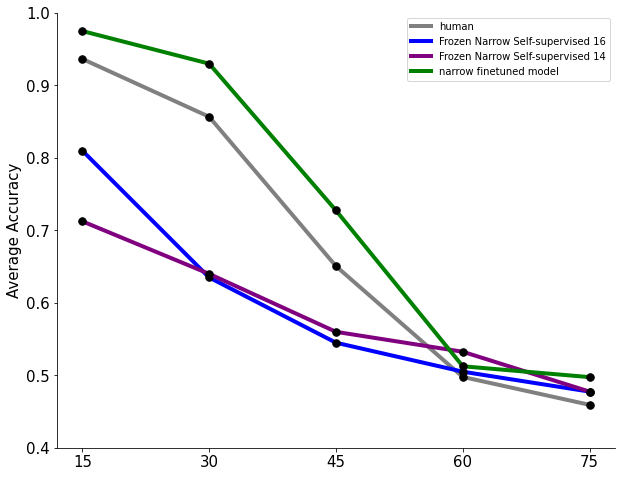

In [597]:
plt.figure(figsize=(10,8))



plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],color='gray',linewidth=4,label='human')
plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],'.',color='k',markersize=15)





plt.plot(unique_beta_vals,beta_acc_barlow_frozen_narrow16,linewidth=4,label='Frozen Narrow Self-supervised 16',color='blue')
plt.plot(unique_beta_vals,beta_acc_barlow_frozen_narrow16,'.',color='k',markersize=15)


plt.plot(unique_beta_vals,beta_acc_supervised_frozen_narrow14,linewidth=4,label='Frozen Narrow Self-supervised 14',color='purple')
plt.plot(unique_beta_vals,beta_acc_supervised_frozen_narrow14,'.',color='k',markersize=15)



plt.plot(unique_beta_vals,narrow_unique_beta_acc,linewidth=4,label='narrow finetuned model',color='g')
plt.plot(unique_beta_vals,narrow_unique_beta_acc,'.',color='k',markersize=15)

# plt.plot(unique_beta_vals,broad_unique_beta_acc,linewidth=4,label='broad finetuned mode',color='r')
# plt.plot(unique_beta_vals,broad_unique_beta_acc,'.',color='k',markersize=15)






plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)



plt.xticks(unique_beta_vals,fontsize=15)
plt.yticks(fontsize=15) 

plt.ylabel('Average Accuracy',fontsize=15)

plt.ylim(0.4,1.0)
plt.legend()
plt.show()

# Section 2: Multiple models

In [682]:
def get_model_signal_strength(model,human_img_signal):
    contour_present=None
    contour_absent=None

    ### When contour is present
    psychophysics_dataset_norm = Psychophysics_Dataset(root=os.path.expanduser('/home/jovyan/work/Datasets/contour_integration/model-psychophysics/experiment_1/'),transform=data_transform,get_B=[0,15,30,45,60,75],get_D=[32],get_A=[0],get_contour='contour')
    psychophysics_loader_norm=torch.utils.data.DataLoader(dataset=psychophysics_dataset_norm, batch_size=15, num_workers=num_workers, shuffle=False)



    all_betas=[]
    all_labels=[]
    all_outputs=[]
    all_preds=[]
    all_recorder_path=[]


    for (inputs, b, d, a, nel, labels, record) in psychophysics_loader_norm:
        inputs=inputs.to(device)
        output=model.forward(inputs).detach().cpu()
        _, preds = torch.max(output, 1)

        all_preds.append(preds)

        all_outputs.append(output)
        all_betas.append(b)
        all_labels.append(labels)
        all_recorder_path.append(np.array(record))

    all_betas=torch.cat(all_betas).numpy()
    all_labels=torch.cat(all_labels).numpy()
    all_preds=torch.cat(all_preds).numpy()
    all_outputs=torch.cat(all_outputs).numpy()
    all_recorder_path=np.concatenate(all_recorder_path)

    contour_present=all_outputs


    #####################################################################################################################

    ### When contour is absent
    psychophysics_dataset_norm = Psychophysics_Dataset(root=os.path.expanduser('/home/jovyan/work/Datasets/contour_integration/model-psychophysics/experiment_1/'),transform=data_transform,get_B=[0,15,30,45,60,75],get_D=[32],get_A=[0],get_contour='control')
    psychophysics_loader_norm=torch.utils.data.DataLoader(dataset=psychophysics_dataset_norm, batch_size=15, num_workers=num_workers, shuffle=False)



    all_betas=[]
    all_labels=[]
    all_outputs=[]
    all_preds=[]
    all_recorder_path=[]


    for (inputs, b, d, a, nel, labels, record) in psychophysics_loader_norm:
        inputs=inputs.to(device)
        output=model.forward(inputs).detach().cpu()
        _, preds = torch.max(output, 1)

        all_preds.append(preds)

        # all_outputs.append(softmax_layer(output))
        all_outputs.append(output)

        all_betas.append(b)
        all_labels.append(labels)
        all_recorder_path.append(np.array(record))

    all_betas=torch.cat(all_betas).numpy()
    all_labels=torch.cat(all_labels).numpy()
    all_preds=torch.cat(all_preds).numpy()
    all_outputs=torch.cat(all_outputs).numpy()
    all_recorder_path=np.concatenate(all_recorder_path)

    contour_absent=all_outputs
    
    
    model_img_signal=((contour_present - contour_absent)/np.sqrt(2))[:,1]
    model_human_corr=np.corrcoef(model_img_signal,human_img_signal)[0][1]
    
    
    return model_human_corr, model_img_signal

In [683]:
def get_model_beta_acc(model):
    psychophysics_dataset_norm = Psychophysics_Dataset(root=os.path.expanduser('/home/jovyan/work/Datasets/contour_integration/model-psychophysics/experiment_1/'),transform=data_transform,get_B=[0,15,30,45,60,75],get_D=[32],get_A=[0],get_contour='all')
    psychophysics_loader_norm=torch.utils.data.DataLoader(dataset=psychophysics_dataset_norm, batch_size=15, num_workers=num_workers, shuffle=False)



    all_betas=[]
    all_labels=[]
    all_outputs=[]
    all_preds=[]
    all_recorder_path=[]


    for (inputs, b, d, a, nel, labels, record) in tqdm(psychophysics_loader_norm,disable=True):
        inputs=inputs.to(device)
        output=model.forward(inputs).detach().cpu()
        _, preds = torch.max(output, 1)

        all_preds.append(preds)

        all_outputs.append(output)
        all_betas.append(b)
        all_labels.append(labels)
        all_recorder_path.append(np.array(record))

    all_betas=torch.cat(all_betas).numpy()
    all_labels=torch.cat(all_labels).numpy()
    all_preds=torch.cat(all_preds).numpy()
    all_outputs=torch.cat(all_outputs).numpy()
    all_recorder_path=np.concatenate(all_recorder_path)

    unique_beta_vals=np.unique(all_betas)
    model_unique_beta_acc=[]


    for i in unique_beta_vals:

        acc=np.mean(all_labels[np.where(all_betas==i)[0]] == all_preds[np.where(all_betas==i)[0]])
        model_unique_beta_acc.append(acc)
    
    return model_unique_beta_acc

# A) Running for 1 model

In [684]:
model_human_corr, _ = get_model_signal_strength(loaded_spliced_model,human_img_signal)
model_human_corr

0.16014143277792495

In [685]:
get_model_beta_acc(loaded_spliced_model)

[0.565, 0.5225, 0.5125, 0.495, 0.49]

# B) Running for multiple models

In [692]:
###################################################################################################################
# model_list_files = glob.glob("../dev/new_ccn23/varying_ITM_largeRF/*.pt")
model_list_files = glob.glob("../dev/new_ccn23/last_fig_6/*.pt")
###################################################################################################################

## Narrow
###################################################################################################################
# model_list_files = glob.glob("../dev/new_ccn23/alexnet-barlow-regim-barlow_frozen_narrow/*.pt")
###################################################################################################################

###################################################################################################################
# model_list_files = glob.glob("../dev/new_ccn23/alexnet_regimagenet_categ_frozen_narrow/*.pt")
###################################################################################################################

## Broad
##################################################################################################################
# model_list_files = glob.glob("../dev/new_ccn23/alexnet-barlow-regim-barlow_frozen_broad/*.pt")
##################################################################################################################




model_list_files=sorted(model_list_files)

In [693]:
model_list_files

['../dev/new_ccn23/last_fig_6/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune_beta_020.pt',
 '../dev/new_ccn23/last_fig_6/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune_broad.pt',
 '../dev/new_ccn23/last_fig_6/model_alexnet-random-nodata-notask_layer_avgpool_mode_finetune_beta_020.pt',
 '../dev/new_ccn23/last_fig_6/model_alexnet-random-nodata-notask_layer_avgpool_mode_finetune_broad.pt']

In [694]:
model_human_corr_list=[]
model_beta_acc_list=[]

for i,file in tqdm(enumerate(model_list_files)):
    print(file)
    checkpoint=torch.load(file)
    loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device=device)
    loaded_spliced_model.load_state_dict(checkpoint['model_state_dict'],strict=False)
    
    model_human_corr,_ = get_model_signal_strength(loaded_spliced_model,human_img_signal)
    model_human_corr_list.append(model_human_corr)
    model_beta_acc_list.append(get_model_beta_acc(loaded_spliced_model))

0it [00:00, ?it/s]

../dev/new_ccn23/last_fig_6/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune_beta_020.pt
../dev/new_ccn23/last_fig_6/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune_broad.pt
../dev/new_ccn23/last_fig_6/model_alexnet-random-nodata-notask_layer_avgpool_mode_finetune_beta_020.pt
../dev/new_ccn23/last_fig_6/model_alexnet-random-nodata-notask_layer_avgpool_mode_finetune_broad.pt


In [695]:
model_beta_acc_list=np.array(model_beta_acc_list)

In [696]:
for i,file in tqdm(enumerate(model_list_files)):
    print(file.split('/')[-1],' \t\t Corr:',model_human_corr_list[i])

0it [00:00, ?it/s]

model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune_beta_020.pt  		 Corr: 0.7680396077997287
model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune_broad.pt  		 Corr: 0.19076372138213038
model_alexnet-random-nodata-notask_layer_avgpool_mode_finetune_beta_020.pt  		 Corr: 0.2450965546540889
model_alexnet-random-nodata-notask_layer_avgpool_mode_finetune_broad.pt  		 Corr: 0.16014143277792495


In [697]:
model_beta_acc_list

array([[0.975 , 0.93  , 0.7275, 0.5125, 0.4975],
       [0.9175, 0.9075, 0.935 , 0.905 , 0.86  ],
       [0.5825, 0.545 , 0.5125, 0.505 , 0.4875],
       [0.565 , 0.5225, 0.5125, 0.495 , 0.49  ]])

# C) Run it on all finetuned models for multiple curvatures from single layer 

In [700]:
model_list_files = glob.glob("../dev/new_ccn23/alexnet_regimagenet_categ_frozen_narrow/*.pt")
# model_list_files = glob.glob("../dev/new_ccn23/alexnet-barlow-regim-barlow_frozen_narrow/*.pt")


model_list_files=sorted(model_list_files)

In [701]:
model_list_files

['../dev/new_ccn23/alexnet_regimagenet_categ_frozen_narrow/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_frozen_beta_000.pt',
 '../dev/new_ccn23/alexnet_regimagenet_categ_frozen_narrow/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_frozen_beta_002.pt',
 '../dev/new_ccn23/alexnet_regimagenet_categ_frozen_narrow/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_frozen_beta_004.pt',
 '../dev/new_ccn23/alexnet_regimagenet_categ_frozen_narrow/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_frozen_beta_008.pt',
 '../dev/new_ccn23/alexnet_regimagenet_categ_frozen_narrow/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_frozen_beta_010.pt',
 '../dev/new_ccn23/alexnet_regimagenet_categ_frozen_narrow/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_frozen_beta_012.pt',
 '../dev/new_ccn23/alexnet_regimagenet_categ_frozen_narrow/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_frozen_beta_014.pt',
 '../dev/new_ccn23/alexnet_regimagenet_categ_frozen_narrow/model_alex

In [702]:
model_human_corr_list=[]
model_beta_acc_list=[]

for i,file in tqdm(enumerate(model_list_files)):
    print(file)
    checkpoint=torch.load(file)
    loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device=device)
    loaded_spliced_model.load_state_dict(checkpoint['model_state_dict'],strict=False)
    
    model_human_corr,_ = get_model_signal_strength(loaded_spliced_model,human_img_signal)
    model_human_corr_list.append(model_human_corr)
    model_beta_acc_list.append(get_model_beta_acc(loaded_spliced_model))

0it [00:00, ?it/s]

../dev/new_ccn23/alexnet_regimagenet_categ_frozen_narrow/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_frozen_beta_000.pt
../dev/new_ccn23/alexnet_regimagenet_categ_frozen_narrow/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_frozen_beta_002.pt
../dev/new_ccn23/alexnet_regimagenet_categ_frozen_narrow/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_frozen_beta_004.pt
../dev/new_ccn23/alexnet_regimagenet_categ_frozen_narrow/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_frozen_beta_008.pt
../dev/new_ccn23/alexnet_regimagenet_categ_frozen_narrow/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_frozen_beta_010.pt
../dev/new_ccn23/alexnet_regimagenet_categ_frozen_narrow/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_frozen_beta_012.pt
../dev/new_ccn23/alexnet_regimagenet_categ_frozen_narrow/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_frozen_beta_014.pt
../dev/new_ccn23/alexnet_regimagenet_categ_frozen_narrow/model_alexnet-pytorch-regim-categ_layer_

In [703]:
model_beta_acc_list=np.array(model_beta_acc_list)

In [704]:
beta_experience=[]
for m in model_list_files:
    beta_experience.append(int(m.split('_')[-1][:-3]))

In [705]:
for i in range(len(beta_experience)):
    print(i,'\t',beta_experience[i],'\t',model_human_corr_list[i])

0 	 0 	 0.4664688608101652
1 	 2 	 0.4695760003591688
2 	 4 	 0.4786739076742571
3 	 8 	 0.5013866944955597
4 	 10 	 0.5069681875141946
5 	 12 	 0.5182204470391819
6 	 14 	 0.5221077741641216
7 	 16 	 0.5180760519826526
8 	 18 	 0.5174374217765999
9 	 20 	 0.5112765300788717
10 	 22 	 0.498831245198925
11 	 24 	 0.4998940559187345
12 	 26 	 0.48766093243416214
13 	 28 	 0.4821499055150224
14 	 30 	 0.4466044168007556
15 	 45 	 0.15316883035751125
16 	 60 	 -0.1219556376360766
17 	 75 	 -0.27048795398875636
18 	 90 	 -0.18880589700349276


In [706]:
print('Highest at',beta_experience[np.argmax(model_human_corr_list)], model_human_corr_list[np.argmax(model_human_corr_list)])

Highest at 14 0.5221077741641216


In [707]:
# root_folder_rename = '../dev/new_ccn23/alexnet-barlow-regim-barlow_frozen_narrow/'
# model_list_files = glob.glob(root_folder_rename + "/*.pt")
# model_list_files=sorted(model_list_files)

# for i in range(len(model_list_files)):
#     old_file_name = model_list_files[i].split('/')[-1]

#     t=old_file_name[:-3].split('_')
#     t[-1] = t[-1].zfill(3)
#     new_file_name = '_'.join(t)+'.pt'
#     # print(old_file_name)
#     # print(new_file_name)
    
#     os.rename(os.path.join(root_folder_rename,old_file_name), os.path.join(root_folder_rename,new_file_name))

### Plotting specific curvatures

In [709]:
# height=[model_human_corr_list[0],model_human_corr_list[8],model_human_corr_list[16],model_human_corr_list[17],model_human_corr_list[18],model_human_corr_list[19]]
# bars=[beta_experience[0],beta_experience[8],beta_experience[16],beta_experience[17],beta_experience[18],beta_experience[19]]




# y_pos = np.arange(len(bars)) / 4.5  + 6
# color=['C0'] * len(bars)
# # color[0]='Red'

# plt.figure(figsize=(10,8))




# plt.gca().bar(y_pos, height, align='center', width=0.06, color=color, alpha=1.0, ecolor='C0', capsize=4)




# plt.axhline(0.0,linestyle='--',color='k')



# plt.xticks(y_pos, bars,fontsize=15,rotation=90)
# plt.yticks(fontsize=15)

# plt.fill_between(y_pos,0.7856633080741112 - 0.009460643283334128, 0.7856633080741112 + 0.009460643283334128,color='gray',alpha=0.6)



# plt.ylim(-1.0,1.0)

# plt.ylabel('Correlation with humans',fontsize=25,labelpad=20)
# plt.xlabel('Training Curvature',fontsize=25,labelpad=20)
# # plt.title('Alexnet Avgpool - Broad vs Narrow Finetuning',fontsize=25)
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['left'].set_visible(True)
# plt.gca().spines['bottom'].set_visible(True)
# plt.show()

### Plotting all beta curvatures

In [710]:
def plot_corr_bar(height=[0.60761674,0.68399041,0.63317831,0.17475693,-0.49703771,-0.55975402],bars=[0,15,30,45,60,75],clip_range=True,show_bar=True,show_zero_corr=True):
    y_pos = np.arange(len(bars)) / 4.5
    color=['green'] * len(bars)

    plt.figure(figsize=(10,8))
    
    plt.fill_between(y_pos,0.7856633080741112 - 0.009460643283334128, 0.7856633080741112 + 0.009460643283334128,color='gray',alpha=0.6)

    if(show_bar):
        plt.gca().bar(y_pos, height, align='center', width=0.06, color=color, alpha=0.2, ecolor='C0', capsize=4)
    
    
    
    
    plt.plot(y_pos,height,'-',color='C0',linewidth=4)
    plt.plot(y_pos,height,'.',color='k',markersize=15)
    
    
    
    
    
    if(show_zero_corr):
        plt.axhline(0.0,linestyle='-',color='r')

    for i in y_pos:
        plt.axvline(i,linestyle='--',alpha=0.1,color='k')

    max_value = np.argmax(height)
    plt.plot(y_pos[max_value],height[max_value],'.',color='green',markersize=25)
    plt.axvline(y_pos[max_value],linestyle='--',alpha=0.5,color='green')
    
    
    plt.xticks(y_pos, bars,fontsize=15)
    plt.yticks(fontsize=15)
    
    
    
    if(clip_range):
        # plt.ylim(-1.0,1.0)
        plt.gca().set_ylim(top=0.7)
        
    plt.ylabel('Correlation with humans',fontsize=25,labelpad=20)
    plt.xlabel('Training Curvature',fontsize=25,labelpad=20)
    # plt.title('Alexnet Avgpool - Constrained Finetuning',fontsize=25)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(True)
    plt.gca().spines['bottom'].set_visible(True)
    plt.savefig('./dev/mauscript_figures/empirical-2_corr.png', format='png', dpi=600,bbox_inches='tight')
    plt.show()

In [711]:
beta_experience

[0, 2, 4, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 45, 60, 75, 90]

In [712]:
beta_experience[:8]+beta_experience[9:-4]


[0, 2, 4, 8, 10, 12, 14, 16, 20, 22, 24, 26, 28, 30]

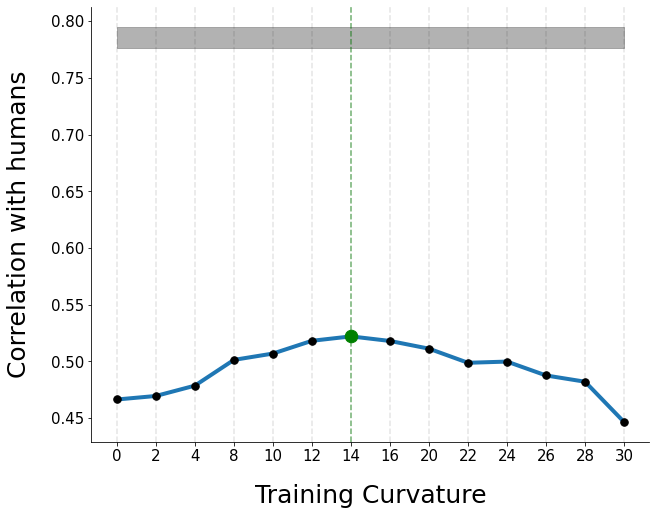

In [713]:
plot_corr_bar(height=model_human_corr_list[:8]+model_human_corr_list[9:-4],bars=beta_experience[:8]+beta_experience[9:-4],clip_range=False,show_bar=False,show_zero_corr=False)





# D) Runing on main figure plots

# D1 - MODELHUMANBEHAIOR AND MODELHUMANCORR

In [1264]:
model_list_files = glob.glob("../dev/new_ccn23/last_fig_6/*.pt")
model_list_files=sorted(model_list_files)

In [1265]:
model_list_files

['../dev/new_ccn23/last_fig_6/model_alexnet-barlow-regim-barlow_layer_backbone_mode_frozen_beta_016.pt',
 '../dev/new_ccn23/last_fig_6/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune_beta_020.pt',
 '../dev/new_ccn23/last_fig_6/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune_broad.pt',
 '../dev/new_ccn23/last_fig_6/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_frozen_beta_014.pt',
 '../dev/new_ccn23/last_fig_6/model_alexnet-random-nodata-notask_layer_avgpool_mode_finetune_beta_020.pt',
 '../dev/new_ccn23/last_fig_6/model_alexnet-random-nodata-notask_layer_avgpool_mode_finetune_broad.pt',
 '../dev/new_ccn23/last_fig_6/model_alexnet-random-nodata-notask_layer_avgpool_mode_frozen_beta_014.pt']

In [1266]:
model_human_corr_list=[]
model_beta_acc_list=[]
model_img_signal_list=[]

for i,file in tqdm(enumerate(model_list_files)):
    print(file)
    checkpoint=torch.load(file)
    loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device=device)
    loaded_spliced_model.load_state_dict(checkpoint['model_state_dict'],strict=False)
    
    model_human_corr,model_img_signal = get_model_signal_strength(loaded_spliced_model,human_img_signal)
    model_human_corr_list.append(model_human_corr)
    model_beta_acc_list.append(get_model_beta_acc(loaded_spliced_model))
    
    model_img_signal_list.append(model_img_signal)

0it [00:00, ?it/s]

../dev/new_ccn23/last_fig_6/model_alexnet-barlow-regim-barlow_layer_backbone_mode_frozen_beta_016.pt
... loading checkpoint: /home/jovyan/work/Testing_Updated_Dropbox/Dropbox (Harvard University)/Research-Doshi/Projects/PROJECT_mid_rep_updated/PROJECT_contour_integration/3_manuscript_beta/dev/base_model_weights/barlow_reserailized.pt
... state loaded.
../dev/new_ccn23/last_fig_6/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune_beta_020.pt
../dev/new_ccn23/last_fig_6/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune_broad.pt
../dev/new_ccn23/last_fig_6/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_frozen_beta_014.pt
../dev/new_ccn23/last_fig_6/model_alexnet-random-nodata-notask_layer_avgpool_mode_finetune_beta_020.pt
../dev/new_ccn23/last_fig_6/model_alexnet-random-nodata-notask_layer_avgpool_mode_finetune_broad.pt
../dev/new_ccn23/last_fig_6/model_alexnet-random-nodata-notask_layer_avgpool_mode_frozen_beta_014.pt


In [1267]:
model_beta_acc_list = np.array(model_beta_acc_list)
model_img_signal_list = np.array(model_img_signal_list)

In [1268]:
for i,file in tqdm(enumerate(model_list_files)):
    print(i,'\t',file.split('/')[-1],' \t\t Corr:',model_human_corr_list[i])

0it [00:00, ?it/s]

0 	 model_alexnet-barlow-regim-barlow_layer_backbone_mode_frozen_beta_016.pt  		 Corr: 0.6008245934449947
1 	 model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune_beta_020.pt  		 Corr: 0.7680396077997287
2 	 model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune_broad.pt  		 Corr: 0.19076372138213038
3 	 model_alexnet-pytorch-regim-categ_layer_avgpool_mode_frozen_beta_014.pt  		 Corr: 0.5221077741641216
4 	 model_alexnet-random-nodata-notask_layer_avgpool_mode_finetune_beta_020.pt  		 Corr: 0.2450965546540889
5 	 model_alexnet-random-nodata-notask_layer_avgpool_mode_finetune_broad.pt  		 Corr: 0.16014143277792495
6 	 model_alexnet-random-nodata-notask_layer_avgpool_mode_frozen_beta_014.pt  		 Corr: 0.1363510032234953


## Plots

### Plot Fig. 6A

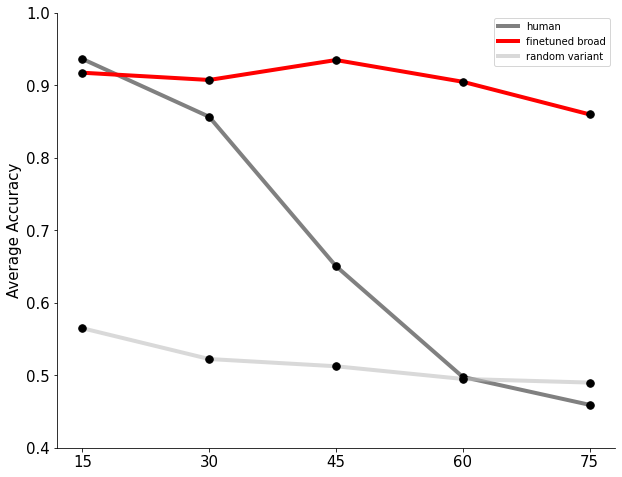

In [1274]:
plt.figure(figsize=(10,8))



plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],color='gray',linewidth=4,label='human')
plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],'.',color='k',markersize=15)

plt.plot(unique_beta_vals,model_beta_acc_list[2],linewidth=4,label='finetuned broad',color='r')
plt.plot(unique_beta_vals,model_beta_acc_list[2],'.',color='k',markersize=15)

plt.plot(unique_beta_vals,model_beta_acc_list[5],linewidth=4,label='random variant',color='silver',alpha=0.6)
plt.plot(unique_beta_vals,model_beta_acc_list[5],'.',color='k',markersize=15)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)



plt.xticks(unique_beta_vals,fontsize=15)
plt.yticks(fontsize=15) 

plt.ylabel('Average Accuracy',fontsize=15)

plt.ylim(0.4,1.0)
plt.legend()
plt.savefig('./dev/mauscript_figures/fig6a_modelhumanbehav.png', format='png', dpi=600,bbox_inches='tight')
plt.show()

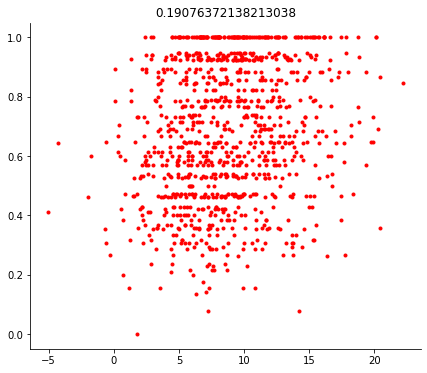

In [1275]:
plt.figure(figsize=(7,6))
plt.plot(model_img_signal_list[2],human_img_signal,'.',color='red')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title(model_human_corr_list[2])
plt.savefig('./dev/mauscript_figures/fig6a_modelhumancorr.png', format='png', dpi=600,bbox_inches='tight')
plt.show()

In [1278]:
model_beta_acc_list[2]

array([0.9175, 0.9075, 0.935 , 0.905 , 0.86  ])

### Plot Fig. 6B

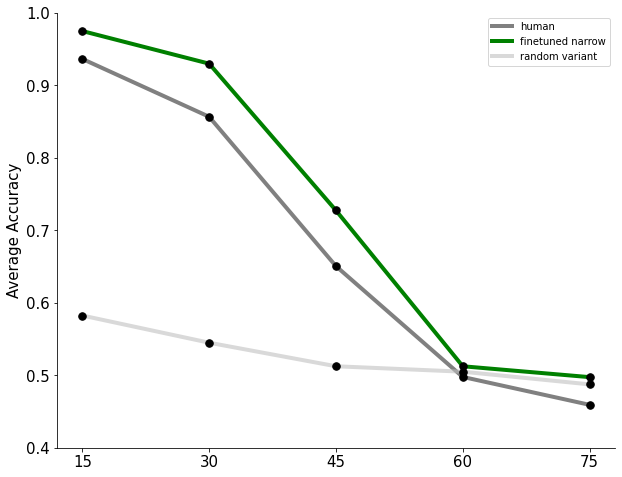

In [1276]:
plt.figure(figsize=(10,8))



plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],color='gray',linewidth=4,label='human')
plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],'.',color='k',markersize=15)

plt.plot(unique_beta_vals,model_beta_acc_list[1],linewidth=4,label='finetuned narrow',color='g')
plt.plot(unique_beta_vals,model_beta_acc_list[1],'.',color='k',markersize=15)

plt.plot(unique_beta_vals,model_beta_acc_list[4],linewidth=4,label='random variant',color='silver',alpha=0.6)
plt.plot(unique_beta_vals,model_beta_acc_list[4],'.',color='k',markersize=15)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)



plt.xticks(unique_beta_vals,fontsize=15)
plt.yticks(fontsize=15) 

plt.ylabel('Average Accuracy',fontsize=15)

plt.ylim(0.4,1.0)
plt.legend()
plt.savefig('./dev/mauscript_figures/fig6b_modelhumanbehav.png', format='png', dpi=600,bbox_inches='tight')
plt.show()

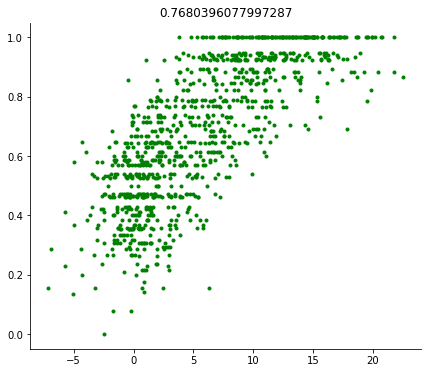

In [1277]:
plt.figure(figsize=(7,6))
plt.plot(model_img_signal_list[1],human_img_signal,'.',color='g')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title(model_human_corr_list[1])
plt.savefig('./dev/mauscript_figures/fig6b_modelhumancorr.png', format='png', dpi=600,bbox_inches='tight')
plt.show()

In [1279]:
model_beta_acc_list[1]

array([0.975 , 0.93  , 0.7275, 0.5125, 0.4975])

### Plot Fig. 6C

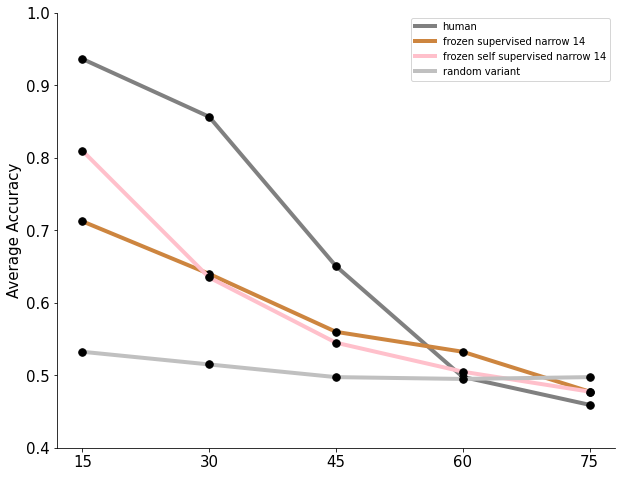

In [822]:
plt.figure(figsize=(10,8))



plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],color='gray',linewidth=4,label='human')
plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],'.',color='k',markersize=15)

plt.plot(unique_beta_vals,model_beta_acc_list[3],linewidth=4,label='frozen supervised narrow 14',color='peru')
plt.plot(unique_beta_vals,model_beta_acc_list[3],'.',color='k',markersize=15)


plt.plot(unique_beta_vals,model_beta_acc_list[0],linewidth=4,label='frozen self supervised narrow 14',color='pink')
plt.plot(unique_beta_vals,model_beta_acc_list[0],'.',color='k',markersize=15)


plt.plot(unique_beta_vals,model_beta_acc_list[6],linewidth=4,label='random variant',color='silver',alpha=1.0)
plt.plot(unique_beta_vals,model_beta_acc_list[6],'.',color='k',markersize=15)




plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)



plt.xticks(unique_beta_vals,fontsize=15)
plt.yticks(fontsize=15) 

plt.ylabel('Average Accuracy',fontsize=15)

plt.ylim(0.4,1.0)
plt.legend()
plt.savefig('./dev/mauscript_figures/fig6c_modelhumanbehav.png', format='png', dpi=600,bbox_inches='tight')
plt.show()

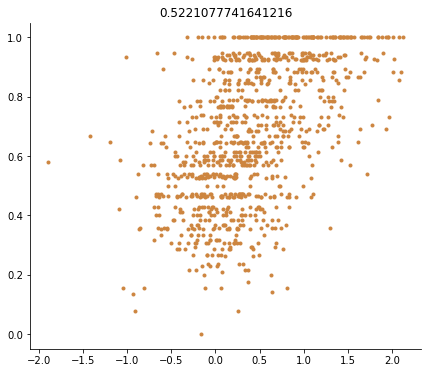

In [828]:
plt.figure(figsize=(7,6))

plt.plot(model_img_signal_list[3],human_img_signal,'.',color='peru')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title(model_human_corr_list[3])
plt.savefig('./dev/mauscript_figures/fig6c_modelhumancorr-sup.png', format='png', dpi=600,bbox_inches='tight')
plt.show()

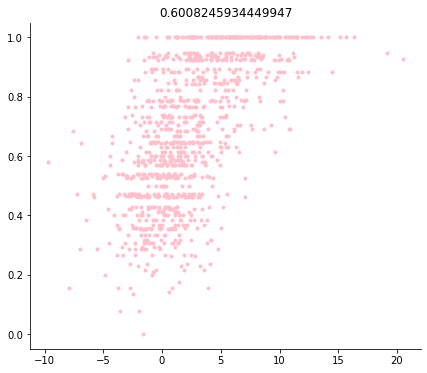

In [829]:
plt.figure(figsize=(7,6))
plt.plot(model_img_signal_list[0],human_img_signal,'.',color='pink')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title(model_human_corr_list[0])
plt.savefig('./dev/mauscript_figures/fig6c_modelhumancorr-selfsup.png', format='png', dpi=600,bbox_inches='tight')
plt.show()

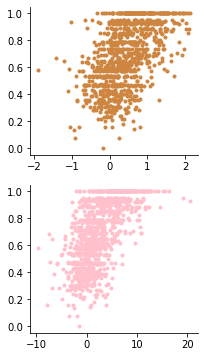

In [830]:
plt.figure(figsize=(3,6))

plt.subplot(2,1,1)
plt.plot(model_img_signal_list[3],human_img_signal,'.',color='peru')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.subplot(2,1,2)
plt.plot(model_img_signal_list[0],human_img_signal,'.',color='pink')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

# D2 - CONTROLLED REARING

### Plot6B

In [867]:
model_list_files = glob.glob("../dev/new_ccn23/alexnet_regimagenet_categ_finetune_narrow/*.pt")
model_list_files=sorted(model_list_files)

In [868]:
print(len(model_list_files))

21


In [869]:
model_human_corr_list=[]
model_beta_acc_list=[]

for i,file in tqdm(enumerate(model_list_files)):
    print(file)
    checkpoint=torch.load(file)
    loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device=device)
    loaded_spliced_model.load_state_dict(checkpoint['model_state_dict'],strict=False)
    
    model_human_corr,_ = get_model_signal_strength(loaded_spliced_model,human_img_signal)
    model_human_corr_list.append(model_human_corr)
    model_beta_acc_list.append(get_model_beta_acc(loaded_spliced_model))

model_beta_acc_list=np.array(model_beta_acc_list)
beta_experience=[]
for m in model_list_files:
    beta_experience.append(int(m.split('_')[-1][:-3]))

print('Highest at',beta_experience[np.argmax(model_human_corr_list)], model_human_corr_list[np.argmax(model_human_corr_list)])

0it [00:00, ?it/s]

../dev/new_ccn23/alexnet_regimagenet_categ_finetune_narrow/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune_beta_000.pt
../dev/new_ccn23/alexnet_regimagenet_categ_finetune_narrow/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune_beta_002.pt
../dev/new_ccn23/alexnet_regimagenet_categ_finetune_narrow/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune_beta_004.pt
../dev/new_ccn23/alexnet_regimagenet_categ_finetune_narrow/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune_beta_006.pt
../dev/new_ccn23/alexnet_regimagenet_categ_finetune_narrow/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune_beta_008.pt
../dev/new_ccn23/alexnet_regimagenet_categ_finetune_narrow/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune_beta_010.pt
../dev/new_ccn23/alexnet_regimagenet_categ_finetune_narrow/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_finetune_beta_012.pt
../dev/new_ccn23/alexnet_regimagenet_categ_finetune_narrow/model_alex

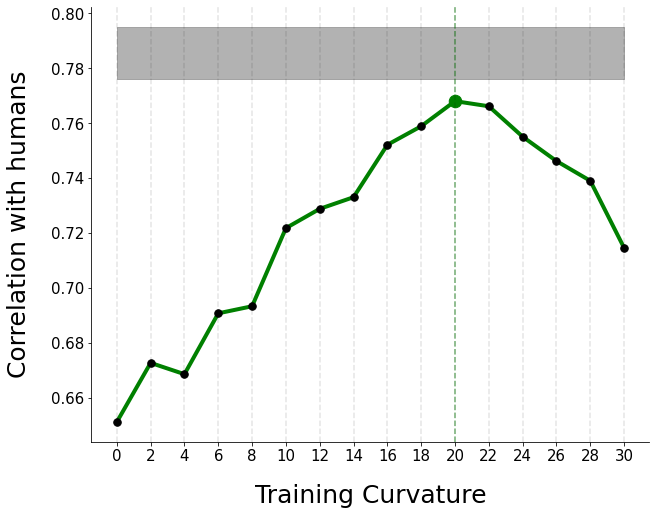

In [872]:
bars = beta_experience[:8]+beta_experience[9:-4]
height=model_human_corr_list[:8]+model_human_corr_list[9:-4]


y_pos = np.arange(len(bars)) / 4.5
color=['green'] * len(bars)

plt.figure(figsize=(10,8))

plt.fill_between(y_pos,0.7856633080741112 - 0.009460643283334128, 0.7856633080741112 + 0.009460643283334128,color='gray',alpha=0.6)

plt.plot(y_pos,height,'-',color='green',linewidth=4)
plt.plot(y_pos,height,'.',color='k',markersize=15)


max_value = np.argmax(height)
plt.plot(y_pos[max_value],height[max_value],'.',color='green',markersize=25)
plt.axvline(y_pos[max_value],linestyle='--',alpha=0.5,color='green')


for i in y_pos:
    plt.axvline(i,linestyle='--',alpha=0.1,color='k')



plt.xticks(y_pos, bars,fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Correlation with humans',fontsize=25,labelpad=20)
plt.xlabel('Training Curvature',fontsize=25,labelpad=20)
# plt.title('Alexnet Avgpool - Constrained Finetuning',fontsize=25)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.savefig('./dev/mauscript_figures/fig6b_controlledrearing.png', format='png', dpi=600,bbox_inches='tight')
plt.show()

### Plot6C

In [877]:
model_list_files = glob.glob("../dev/new_ccn23/alexnet_regimagenet_categ_frozen_narrow/*.pt")
model_list_files=sorted(model_list_files)

In [878]:
model_human_corr_list=[]
model_beta_acc_list=[]

for i,file in tqdm(enumerate(model_list_files)):
    print(file)
    checkpoint=torch.load(file)
    loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device=device)
    loaded_spliced_model.load_state_dict(checkpoint['model_state_dict'],strict=False)
    
    model_human_corr,_ = get_model_signal_strength(loaded_spliced_model,human_img_signal)
    model_human_corr_list.append(model_human_corr)
    model_beta_acc_list.append(get_model_beta_acc(loaded_spliced_model))

model_beta_acc_list=np.array(model_beta_acc_list)
beta_experience=[]
for m in model_list_files:
    beta_experience.append(int(m.split('_')[-1][:-3]))

print('Highest at',beta_experience[np.argmax(model_human_corr_list)], model_human_corr_list[np.argmax(model_human_corr_list)])

0it [00:00, ?it/s]

../dev/new_ccn23/alexnet_regimagenet_categ_frozen_narrow/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_frozen_beta_000.pt
../dev/new_ccn23/alexnet_regimagenet_categ_frozen_narrow/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_frozen_beta_002.pt
../dev/new_ccn23/alexnet_regimagenet_categ_frozen_narrow/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_frozen_beta_004.pt
../dev/new_ccn23/alexnet_regimagenet_categ_frozen_narrow/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_frozen_beta_006.pt
../dev/new_ccn23/alexnet_regimagenet_categ_frozen_narrow/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_frozen_beta_008.pt
../dev/new_ccn23/alexnet_regimagenet_categ_frozen_narrow/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_frozen_beta_010.pt
../dev/new_ccn23/alexnet_regimagenet_categ_frozen_narrow/model_alexnet-pytorch-regim-categ_layer_avgpool_mode_frozen_beta_012.pt
../dev/new_ccn23/alexnet_regimagenet_categ_frozen_narrow/model_alexnet-pytorch-regim-categ_layer_

In [879]:
supervised_model_human_corr_list = model_human_corr_list

In [880]:
len(supervised_model_human_corr_list)

21

In [881]:
model_list_files = glob.glob("../dev/new_ccn23/alexnet-barlow-regim-barlow_frozen_narrow/*.pt")
model_list_files=sorted(model_list_files)

In [882]:
model_human_corr_list=[]
model_beta_acc_list=[]

for i,file in tqdm(enumerate(model_list_files)):
    print(file)
    checkpoint=torch.load(file)
    loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device=device)
    loaded_spliced_model.load_state_dict(checkpoint['model_state_dict'],strict=False)
    
    model_human_corr,_ = get_model_signal_strength(loaded_spliced_model,human_img_signal)
    model_human_corr_list.append(model_human_corr)
    model_beta_acc_list.append(get_model_beta_acc(loaded_spliced_model))

model_beta_acc_list=np.array(model_beta_acc_list)
beta_experience=[]
for m in model_list_files:
    beta_experience.append(int(m.split('_')[-1][:-3]))

print('Highest at',beta_experience[np.argmax(model_human_corr_list)], model_human_corr_list[np.argmax(model_human_corr_list)])

0it [00:00, ?it/s]

../dev/new_ccn23/alexnet-barlow-regim-barlow_frozen_narrow/model_alexnet-barlow-regim-barlow_layer_backbone_mode_frozen_beta_000.pt
... loading checkpoint: /home/jovyan/work/Testing_Updated_Dropbox/Dropbox (Harvard University)/Research-Doshi/Projects/PROJECT_mid_rep_updated/PROJECT_contour_integration/3_manuscript_beta/dev/base_model_weights/barlow_reserailized.pt
... state loaded.
../dev/new_ccn23/alexnet-barlow-regim-barlow_frozen_narrow/model_alexnet-barlow-regim-barlow_layer_backbone_mode_frozen_beta_002.pt
... loading checkpoint: /home/jovyan/work/Testing_Updated_Dropbox/Dropbox (Harvard University)/Research-Doshi/Projects/PROJECT_mid_rep_updated/PROJECT_contour_integration/3_manuscript_beta/dev/base_model_weights/barlow_reserailized.pt
... state loaded.
../dev/new_ccn23/alexnet-barlow-regim-barlow_frozen_narrow/model_alexnet-barlow-regim-barlow_layer_backbone_mode_frozen_beta_004.pt
... loading checkpoint: /home/jovyan/work/Testing_Updated_Dropbox/Dropbox (Harvard University)/Res

In [883]:
selfsupervised_model_human_corr_list = model_human_corr_list

In [884]:
len(selfsupervised_model_human_corr_list)

21

#### Plot

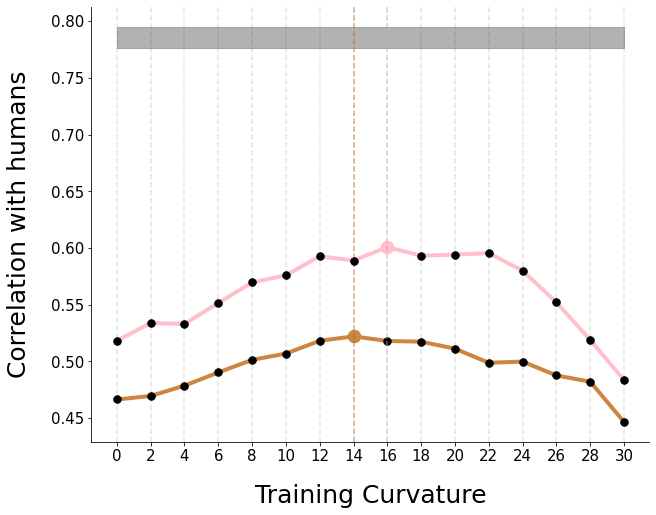

In [886]:
bars = beta_experience[:8]+beta_experience[9:-4]
height1 = supervised_model_human_corr_list[:8]+supervised_model_human_corr_list[9:-4]
height2 = selfsupervised_model_human_corr_list[:8]+selfsupervised_model_human_corr_list[9:-4]

y_pos = np.arange(len(bars)) / 4.5
color=['green'] * len(bars)

plt.figure(figsize=(10,8))

plt.fill_between(y_pos,0.7856633080741112 - 0.009460643283334128, 0.7856633080741112 + 0.009460643283334128,color='gray',alpha=0.6)




plt.plot(y_pos,height1,'-',color='peru',linewidth=4)
plt.plot(y_pos,height1,'.',color='k',markersize=15)
max_value = np.argmax(height1)
plt.plot(y_pos[max_value],height1[max_value],'.',color='peru',markersize=25)
plt.axvline(y_pos[max_value],linestyle='--',alpha=0.5,color='peru')




plt.plot(y_pos,height2,'-',color='pink',linewidth=4)
plt.plot(y_pos,height2,'.',color='k',markersize=15)
max_value = np.argmax(height2)
plt.plot(y_pos[max_value],height2[max_value],'.',color='pink',markersize=25)
plt.axvline(y_pos[max_value],linestyle='--',alpha=0.5,color='pink')




for i in y_pos:
    plt.axvline(i,linestyle='--',alpha=0.1,color='k')



plt.xticks(y_pos, bars,fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Correlation with humans',fontsize=25,labelpad=20)
plt.xlabel('Training Curvature',fontsize=25,labelpad=20)
# plt.title('Alexnet Avgpool - Constrained Finetuning',fontsize=25)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.savefig('./dev/mauscript_figures/fig6c_controlledrearing.png', format='png', dpi=600,bbox_inches='tight')
plt.show()

# RESUME

# Running it on all single beta values

In [ ]:

#####################################################################################################################
# model_list_files = glob.glob("../dev/new_ccn23/alexnet_regimagenet_categ_finetune_broad/*.pt")
# model_list_files = glob.glob("../dev/new_ccn23/alexnet_regimagenet_categ_frozen_broad/*.pt")
# model_list_files = glob.glob("../dev/new_ccn23/alexnet-styim-categ_frozen_broad/*.pt")
# model_list_files = glob.glob("../dev/new_ccn23/alexnet-random-nodata-notask_frozen_broad/*.pt")
#####################################################################################################################


#####################################################################################################################
# model_list_files = glob.glob("../dev/new_ccn23/alexnet_regimagenet_categ_finetune_narrow/*.pt")
# model_list_files = glob.glob("../dev/new_ccn23/alexnet_regimagenet_categ_finetune_narrow_classifier_1/*.pt")
# model_list_files = glob.glob("../dev/new_ccn23/alexnet_regimagenet_categ_finetune_narrow_classifier_2/*.pt")
# model_list_files = glob.glob("../dev/new_ccn23/alexnet_regimagenet_categ_finetune_narrow_classifier_3/*.pt")
# model_list_files = glob.glob("../dev/new_ccn23/alexnet_regimagenet_categ_finetune_narrow_classifier_4/*.pt")
# model_list_files = glob.glob("../dev/new_ccn23/alexnet_regimagenet_categ_finetune_narrow_classifier_5/*.pt")
#####################################################################################################################


#####################################################################################################################
# model_list_files = glob.glob("../dev/new_ccn23/alexnet_regimagenet_categ_frozen_narrow/*.pt")
#####################################################################################################################

####################################################################################################################
# model_list_files = glob.glob("../dev/new_ccn23/alexnet_regimagenet_categ_frozen_narrow/*.pt")
####################################################################################################################




####################################################################################################################
model_list_files = glob.glob("../dev/new_ccn23/alexnet-barlow-regim-barlow_frozen_narrow/*.pt")
####################################################################################################################




model_list_files=sorted(model_list_files)

In [ ]:
model_list_files

In [ ]:
model_human_corr_list=[]
model_beta_acc_list=[]

for i,file in tqdm(enumerate(model_list_files)):
    print(file)
    checkpoint=torch.load(file)
    loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device=device)
    loaded_spliced_model.load_state_dict(checkpoint['model_state_dict'],strict=False)
    
    model_human_corr_list.append(get_model_signal_strength(loaded_spliced_model,human_img_signal))
    model_beta_acc_list.append(get_model_beta_acc(loaded_spliced_model))

In [ ]:
model_beta_acc_list=np.array(model_beta_acc_list)

In [ ]:
beta_experience=[]
for m in model_list_files:
    beta_experience.append(int(m.split('_')[-1][:-3]))

In [ ]:
beta_experience

In [ ]:
model_beta_acc_list

In [ ]:
model_human_corr_list

In [ ]:
len(model_human_corr_list)

In [ ]:
for i in range(len(beta_experience)):
    print(i,'\t',beta_experience[i],'\t',model_human_corr_list[i])

In [ ]:
for i,file in tqdm(enumerate(model_list_files)):
    print(file.split('/')[-1],'\t Corr:',model_human_corr_list[i])

In [ ]:
# ## Setting the broad file

# model_name_corr_dict={'model_name':[],'model_corr':[]}
# filename = './contour_exp1/plots/model_corr_vals_broadfile.csv'


# for m,c in zip(model_list_files,model_human_corr_list):
#     # print(m,'\t',c)
#     model_name_corr_dict['model_name'].append(m)
#     model_name_corr_dict['model_corr'].append(c)




# # Check if the CSV file exists
# if os.path.exists(filename):
#     # Read the existing CSV into a DataFrame
#     df_existing = pd.read_csv(filename)
    
#     # Convert the dictionary to a new DataFrame
#     df_new = pd.DataFrame(model_name_corr_dict)
    
#     # Append the new data to the existing data
#     df_combined = df_existing.append(df_new, ignore_index=True)
    
#     # Save the updated DataFrame back to the CSV
#     df_combined.to_csv(filename, index=False)
# else:
#     # Convert the dictionary to a DataFrame
#     df = pd.DataFrame(model_name_corr_dict)
    
#     # Save the DataFrame to a new CSV file
#     df.to_csv(filename, index=False)


In [ ]:
## Setting the narrow file

model_name_corr_dict={'model_name':[],'model_corr':[]}
filename = './contour_exp1/plots/model_corr_vals_narrowfile.csv'


for m,c in zip(model_list_files,model_human_corr_list):
    # print(m,'\t',c)
    model_name_corr_dict['model_name'].append(m)
    model_name_corr_dict['model_corr'].append(c)




# Check if the CSV file exists
if os.path.exists(filename):
    # Read the existing CSV into a DataFrame
    df_existing = pd.read_csv(filename)
    
    # Convert the dictionary to a new DataFrame
    df_new = pd.DataFrame(model_name_corr_dict)
    
    # Append the new data to the existing data
    df_combined = df_existing.append(df_new, ignore_index=True)
    
    # Save the updated DataFrame back to the CSV
    df_combined.to_csv(filename, index=False)
else:
    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(model_name_corr_dict)
    
    # Save the DataFrame to a new CSV file
    df.to_csv(filename, index=False)


# Plotting correlations for multiple models (layers * type) reading from csv file

In [ ]:
df=pd.read_csv('./contour_exp1/plots/model_corr_vals_broadfile_updated.csv')
set(df['model_type'])

In [ ]:
df[df['model_type']=='Finetune-Contour']

In [ ]:
df[df['model_type']=='Finetune-Contour'].sort_values(by='layer_number')

In [ ]:
color_or_finetune=(78/255,121/255,180/255)
color_or_frozen=(209/255,111/255,28/255)
color_stylized_frozen=(231/255,168/255,34/255)



plt.figure(figsize=(10,10))


plt.plot(np.arange(21),df[df['model_type']=='Finetune-Contour'].sort_values(by='layer_number')['model_corr'],'-',alpha=0.2,linewidth=4,label='Finetune-Contour',color=color_or_finetune)
plt.plot(np.arange(21),df[df['model_type']=='Finetune-Contour'].sort_values(by='layer_number')['model_corr'],'.',alpha=1.0,linewidth=4,label='Finetune-Contour',color=color_or_finetune,markersize=15)

# plt.plot(np.arange(21),df[df['model_type']=='Pretrained-Imagenet'].sort_values(by='layer_number')['model_corr'],'-',alpha=0.8,linewidth=4,label='Pretrained-Imagenet',color=color_or_frozen)
# plt.plot(np.arange(21),df[df['model_type']=='Stylized-Imagenet'].sort_values(by='layer_number')['model_corr'],'-',alpha=0.8,linewidth=4,label='Stylized-Imagenet',color=color_stylized_frozen)
# plt.plot(np.arange(21),df[df['model_type']=='Random'].sort_values(by='layer_number')['model_corr'],'-',alpha=0.8,linewidth=4,label='Random',color='gray')

# plt.plot(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),get_list_acc(sup_regular_finetune_acc['val'],list_layers),alpha=0.8,linewidth=4)
# plt.plot(np.arange(len(get_list_acc(sup_regular_finetune_acc['val'],list_layers))),get_list_acc(sup_regular_finetune_acc['val'],list_layers),'.',color='k',markersize=10,label='supervised regular finetune')


# plt.plot(np.arange(len(get_list_acc(sup_regular_frozen_acc['val'],list_layers))),get_list_acc(sup_regular_frozen_acc['val'],list_layers),alpha=0.4,color='orange',linewidth=4)
# plt.plot(np.arange(len(get_list_acc(sup_regular_frozen_acc['val'],list_layers))),get_list_acc(sup_regular_frozen_acc['val'],list_layers),'.',alpha=0.6,color='k',markersize=10,label='supervised regular finetune')



plt.fill_between(np.arange(21),0.7856633080741112 - 0.009460643283334128, 0.7856633080741112 + 0.009460643283334128,color='gray',alpha=0.6)


plt.axhline(y=0.0,linestyle='--',color='r')


for i in range(21):
    plt.axvline(i,linestyle='--',alpha=0.1,color='k')

plt.xticks(np.arange(21),df[df['model_type']=='Finetune-Contour'].sort_values(by='layer_number')['layer_name'],rotation=90,fontsize=15)
plt.yticks(fontsize=15) 
plt.ylim(-1.0,1.0)
plt.ylabel('Validation Accuracy',fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.legend()
# plt.title('After 100 epochs of training')

plt.savefig('./contour_exp1/plots/model_e1_human-model-corr_broad_alllayers.png', format='png', dpi=600)
plt.show()
    
    

# Plotting correlations for multiple models (layers * diet) reading from csv file

In [ ]:
df=pd.read_csv('./contour_exp1/plots/model_corr_vals_narrowfile_updated.csv')


In [ ]:
df

In [ ]:
model_corr_array=[]
col_names=[]
for i in [14,16,17,18,19,20]:
    model_corr_array.append(list(df[df['layer_number']==i].sort_values(by='beta_val')['model_corr']))
    col_names.append(list(set(df[df['layer_number']==i].sort_values(by='beta_val')['layer_name']))[0])
    
row_names=list(df[df['layer_number']==14].sort_values(by='beta_val')['beta_val'])
model_corr_array=np.transpose(model_corr_array)

plt.figure(figsize=(12,12))
sns.heatmap(model_corr_array, annot=True, fmt=".4f",cmap="viridis", cbar=True, linewidths=.5, xticklabels=col_names, yticklabels=row_names,vmax=0.7856633080741112)
plt.title("Heatmap")
plt.show()

In [ ]:
model_corr_array=[]
col_names=[]
for i in [14,16,17,18,19,20]:

    
    model_corr_array.append(list(df[(df['layer_number']==i) & (~df['beta_val'].isin([90]))].sort_values(by='beta_val')['model_corr']))
    col_names.append(list(set(df[df['layer_number']==i].sort_values(by='beta_val')['layer_name']))[0])
    
row_names=list(df[(df['layer_number']==i) & (~df['beta_val'].isin([90]))].sort_values(by='beta_val')['beta_val'])
model_corr_array=np.transpose(model_corr_array)


plt.figure(figsize=(12,12))
sns.heatmap(model_corr_array, annot=True, fmt=".4f",cmap="viridis", cbar=True, linewidths=.5, xticklabels=col_names, yticklabels=row_names,vmax=0.7856633080741112)
# plt.title("Heatmap")
plt.savefig('./contour_exp1/plots/model_e1_human-model-corr_narrow_alllayers.png', format='png', dpi=600)
plt.show()

In [ ]:
# model_corr_array=[]
# col_names=[]
# for i in [14,16,17,18,19,20]:

    
#     model_corr_array.append(list(df[(df['layer_number']==i) & (df['beta_val'].isin([0,15,45,60,75,90]))].sort_values(by='beta_val')['model_corr']))
#     col_names.append(list(set(df[df['layer_number']==i].sort_values(by='beta_val')['layer_name']))[0])
    
# row_names=list(df[(df['layer_number']==i) & (df['beta_val'].isin([0,15,45,60,75,90]))].sort_values(by='beta_val')['beta_val'])
# model_corr_array=np.transpose(model_corr_array)


# plt.figure(figsize=(12,12))
# sns.heatmap(model_corr_array, annot=True, fmt=".4f",cmap="viridis", cbar=True, linewidths=.5, xticklabels=col_names, yticklabels=row_names)
# plt.title("Heatmap")
# plt.show()

In [ ]:
df[(df['layer_number']==i) & (df['beta_val'].isin([15,45,60,75,90]))]

# Other Plot - corr

### Plot 1:

In [ ]:
height=[model_human_corr_list[0],model_human_corr_list[8],model_human_corr_list[16],model_human_corr_list[17],model_human_corr_list[18],model_human_corr_list[19]]
bars=[beta_experience[0],beta_experience[8],beta_experience[16],beta_experience[17],beta_experience[18],beta_experience[19]]




y_pos = np.arange(len(bars)) / 4.5  + 6
color=['C0'] * len(bars)
# color[0]='Red'

plt.figure(figsize=(10,8))




plt.gca().bar(y_pos, height, align='center', width=0.06, color=color, alpha=1.0, ecolor='C0', capsize=4)




plt.axhline(0.0,linestyle='--',color='k')



plt.xticks(y_pos, bars,fontsize=15,rotation=90)
plt.yticks(fontsize=15)

plt.fill_between(y_pos,0.7856633080741112 - 0.009460643283334128, 0.7856633080741112 + 0.009460643283334128,color='gray',alpha=0.6)



plt.ylim(-1.0,1.0)

plt.ylabel('Correlation with humans',fontsize=25,labelpad=20)
plt.xlabel('Training Curvature',fontsize=25,labelpad=20)
# plt.title('Alexnet Avgpool - Broad vs Narrow Finetuning',fontsize=25)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.show()

In [ ]:
def plot_corr_bar(height=[0.60761674,0.68399041,0.63317831,0.17475693,-0.49703771,-0.55975402],bars=[0,15,30,45,60,75],clip_range=True,show_bar=True,show_zero_corr=True):
    y_pos = np.arange(len(bars)) / 4.5
    color=['green'] * len(bars)

    plt.figure(figsize=(10,8))
    
    plt.fill_between(y_pos,0.7856633080741112 - 0.009460643283334128, 0.7856633080741112 + 0.009460643283334128,color='gray',alpha=0.6)

    if(show_bar):
        plt.gca().bar(y_pos, height, align='center', width=0.06, color=color, alpha=0.2, ecolor='C0', capsize=4)
    
    
    
    
    plt.plot(y_pos,height,'-',color='C0',linewidth=4)
    plt.plot(y_pos,height,'.',color='k',markersize=15)
    
    
    
    
    
    if(show_zero_corr):
        plt.axhline(0.0,linestyle='-',color='r')

    for i in y_pos:
        plt.axvline(i,linestyle='--',alpha=0.1,color='k')

        
    plt.plot(y_pos[10],height[10],'.',color='green',markersize=25)
    plt.axvline(y_pos[10],linestyle='--',alpha=0.5,color='green')
    
    
    plt.xticks(y_pos, bars,fontsize=15)
    plt.yticks(fontsize=15)
    
    
    
    if(clip_range):
        # plt.ylim(-1.0,1.0)
        plt.gca().set_ylim(top=0.7)
        
    plt.ylabel('Correlation with humans',fontsize=25,labelpad=20)
    plt.xlabel('Training Curvature',fontsize=25,labelpad=20)
    # plt.title('Alexnet Avgpool - Constrained Finetuning',fontsize=25)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(True)
    plt.gca().spines['bottom'].set_visible(True)
    plt.savefig('./dev/mauscript_figures/empirical-2_corr.png', format='png', dpi=600,bbox_inches='tight')
    plt.show()

In [ ]:
beta_experience

In [ ]:
beta_experience[:8]+beta_experience[9:-4]


In [ ]:
plot_corr_bar(height=model_human_corr_list[:8]+model_human_corr_list[9:-4],bars=beta_experience[:8]+beta_experience[9:-4],clip_range=False,show_bar=False,show_zero_corr=False)





## Plot - beta_acc

In [ ]:
height=[model_human_corr_list[0],model_human_corr_list[8],model_human_corr_list[16],model_human_corr_list[17],model_human_corr_list[18],model_human_corr_list[19]]
bars=[beta_experience[0],beta_experience[8],beta_experience[16],beta_experience[17],beta_experience[18],beta_experience[19]]

In [ ]:
# plt.figure(figsize=(10,8))


# model_beta_acc_list[0] 


# plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],color='gray',linewidth=5,label='human')
# plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],'.',color='k',markersize=15)



# set_alpha=0.4

# plt.plot(unique_beta_vals,model_beta_acc_list[0] ,linewidth=4,alpha=set_alpha,label=beta_experience[0])
# plt.plot(unique_beta_vals,model_beta_acc_list[0],'.',color='k',markersize=15)


# plt.plot(unique_beta_vals,model_beta_acc_list[8] ,linewidth=4,alpha=set_alpha,label=beta_experience[8])
# plt.plot(unique_beta_vals,model_beta_acc_list[8],'.',color='k',markersize=15)


# plt.plot(unique_beta_vals,model_beta_acc_list[16] , linewidth=4,alpha=set_alpha,label=beta_experience[16])
# plt.plot(unique_beta_vals,model_beta_acc_list[16],'.',color='k',markersize=15)


# plt.plot(unique_beta_vals,model_beta_acc_list[17] , linewidth=4,alpha=set_alpha,label=beta_experience[17])
# plt.plot(unique_beta_vals,model_beta_acc_list[17],'.',color='k',markersize=15)



# plt.plot(unique_beta_vals,model_beta_acc_list[18] , linewidth=4,alpha=set_alpha,label=beta_experience[18])
# plt.plot(unique_beta_vals,model_beta_acc_list[18],'.',color='k',markersize=15)



# plt.plot(unique_beta_vals,model_beta_acc_list[19] , linewidth=4,alpha=set_alpha,label=beta_experience[19])
# plt.plot(unique_beta_vals,model_beta_acc_list[19],'.',color='k',markersize=15)





# # plt.plot(unique_beta_vals,model_unique_beta_acc,linewidth=4,label='model',color='r')
# # plt.plot(unique_beta_vals,model_unique_beta_acc,'.',color='k',markersize=15)


# # plt.plot(unique_beta_vals,narrow_unique_beta_acc,linewidth=4,label='model',color='g')
# # plt.plot(unique_beta_vals,narrow_unique_beta_acc,'.',color='k',markersize=15)

# # plt.plot(unique_beta_vals,broad_unique_beta_acc,linewidth=4,label='model',color='r')
# # plt.plot(unique_beta_vals,broad_unique_beta_acc,'.',color='k',markersize=15)






# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)



# plt.xticks(unique_beta_vals,fontsize=15)
# plt.yticks(fontsize=15) 

# plt.ylabel('Average Accuracy',fontsize=15)

# plt.ylim(0.4,1.0)
# plt.legend()

# plt.show()

In [ ]:
plt.figure(figsize=(15,8))

set_alpha=0.4


plt.subplot(2,3,1)

plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],color='gray',linewidth=4,label='human')
plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],'.',color='k',markersize=15)

plt.plot(unique_beta_vals,model_beta_acc_list[0] ,linewidth=4,alpha=set_alpha,label=beta_experience[0])
plt.plot(unique_beta_vals,model_beta_acc_list[0],'.',color='k',markersize=15)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(unique_beta_vals,fontsize=15)
plt.yticks(fontsize=15) 
plt.ylabel('Average Accuracy',fontsize=15)
plt.ylim(0.4,1.0)







plt.subplot(2,3,2)

plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],color='gray',linewidth=4,label='human')
plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],'.',color='k',markersize=15)

plt.plot(unique_beta_vals,model_beta_acc_list[8] ,linewidth=4,alpha=set_alpha,label=beta_experience[8])
plt.plot(unique_beta_vals,model_beta_acc_list[8],'.',color='k',markersize=15)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(unique_beta_vals,fontsize=15)
plt.yticks(fontsize=15) 
plt.ylabel('Average Accuracy',fontsize=15)
plt.ylim(0.4,1.0)








plt.subplot(2,3,3)

plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],color='gray',linewidth=4,label='human')
plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],'.',color='k',markersize=15)

plt.plot(unique_beta_vals,model_beta_acc_list[16] , linewidth=4,alpha=set_alpha,label=beta_experience[16])
plt.plot(unique_beta_vals,model_beta_acc_list[16],'.',color='k',markersize=15)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(unique_beta_vals,fontsize=15)
plt.yticks(fontsize=15) 
plt.ylabel('Average Accuracy',fontsize=15)
plt.ylim(0.4,1.0)








plt.subplot(2,3,4)

plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],color='gray',linewidth=4,label='human')
plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],'.',color='k',markersize=15)

plt.plot(unique_beta_vals,model_beta_acc_list[17] , linewidth=4,alpha=set_alpha,label=beta_experience[17])
plt.plot(unique_beta_vals,model_beta_acc_list[17],'.',color='k',markersize=15)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(unique_beta_vals,fontsize=15)
plt.yticks(fontsize=15) 
plt.ylabel('Average Accuracy',fontsize=15)
plt.ylim(0.4,1.0)








plt.subplot(2,3,5)

plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],color='gray',linewidth=4,label='human')
plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],'.',color='k',markersize=15)


plt.plot(unique_beta_vals,model_beta_acc_list[18] , linewidth=4,alpha=set_alpha,label=beta_experience[18])
plt.plot(unique_beta_vals,model_beta_acc_list[18],'.',color='k',markersize=15)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(unique_beta_vals,fontsize=15)
plt.yticks(fontsize=15) 
plt.ylabel('Average Accuracy',fontsize=15)
plt.ylim(0.4,1.0)







plt.subplot(2,3,6)

plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],color='gray',linewidth=4,label='human')
plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],'.',color='k',markersize=15)


plt.plot(unique_beta_vals,model_beta_acc_list[19] , linewidth=4,alpha=set_alpha,label=beta_experience[19])
plt.plot(unique_beta_vals,model_beta_acc_list[19],'.',color='k',markersize=15)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(unique_beta_vals,fontsize=15)
plt.yticks(fontsize=15) 
plt.ylabel('Average Accuracy',fontsize=15)
plt.ylim(0.4,1.0)

plt.savefig('./dev/mauscript_figures/empirical-1_beta-acc.png', format='png', dpi=600,bbox_inches='tight')
plt.show()





In [ ]:
plt.figure(figsize=(10,8))


model_beta_acc_list[0] 


plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],color='gray',linewidth=5,label='human')
plt.plot(unique_beta_vals,human_unique_beta_acc[:,0],'.',color='k',markersize=15)

selected_models_idx=list(np.arange(17)[:8]) + list(np.arange(17)[9:])
for models_idx,set_alpha in zip(selected_models_idx,np.linspace(0.1,1.0,16)):
    plt.plot(unique_beta_vals,model_beta_acc_list[models_idx] ,color='C0',linewidth=4,alpha=set_alpha,label=beta_experience[models_idx])
    plt.plot(unique_beta_vals,model_beta_acc_list[models_idx],'.',color='k',markersize=15)
    

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)



plt.xticks(unique_beta_vals,fontsize=15)
plt.yticks(fontsize=15) 

plt.ylabel('Average Accuracy',fontsize=15)

plt.ylim(0.4,1.0)
plt.legend()
plt.savefig('./dev/mauscript_figures/empirical-2_beta-acc.png', format='png', dpi=600,bbox_inches='tight')
plt.show()

# Running it on widths around 20

In [ ]:
model_list_files = glob.glob("../dev/new_ccn23/alexnet_regimagenet_categ_finetune_narrow_around20/*.pt")
model_list_files=sorted(model_list_files)

In [ ]:
model_list_files

In [ ]:
model_human_corr_list=[]
model_beta_acc_list=[]

for i,file in tqdm(enumerate(model_list_files)):
    
    checkpoint=torch.load(file)
    loaded_spliced_model=SpliceModel(checkpoint['training_config']['base_model_name'],checkpoint['training_config']['layer_name'],fine_tune=checkpoint['training_config']['fine_tune'],device=device)
    loaded_spliced_model.load_state_dict(checkpoint['model_state_dict'],strict=False)
    
    model_human_corr_list.append(get_model_signal_strength(loaded_spliced_model,human_img_signal))
    model_beta_acc_list.append(get_model_beta_acc(loaded_spliced_model))

In [ ]:
model_beta_acc_list=np.array(model_beta_acc_list)

In [ ]:
beta_experience=[]
for m in model_list_files:
    beta_experience.append(int(m.split('_')[-1][:-3]))

In [ ]:
beta_experience

In [ ]:
model_beta_acc_list

In [ ]:
model_human_corr_list

In [ ]:
for i in range(len(beta_experience)):
    print(i,'\t',beta_experience[i],'\t',model_human_corr_list[i])

## Plot - corr

In [ ]:

# Sample data
x_single = [20]
y_single = [0.77]

x_center = [20, 20]
y_range_values = [0.7640495414454564, 0.7554520415620296,0.7632444207861586,0.7610120588948686]
x_range = [[18, 22], [16, 24],[14,26], [12, 28]]

plt.figure(figsize=(10,6))

# Plotting single x-values
plt.scatter(x_single, y_single, color='green', label='Single x-values', s=100)

# Plotting x-ranges
for i, (x_start, x_end) in enumerate(x_range):
    x_fill = np.linspace(x_start, x_end, 100)
    y_fill = np.full_like(x_fill, y_range_values[i])
    plt.fill_between(x_fill, 0, y_fill, alpha=0.2, label=f'Range: {x_start}-{x_end}')


plt.axvline(20,linestyle='--',alpha=0.5,color='green')
    
    
plt.ylim(0.65,0.8)
plt.xlim(5,35)

# To avoid duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()

plt.savefig('./dev/mauscript_figures/empirical-3_corr.png', format='png', dpi=600,bbox_inches='tight')

plt.show()


# Beta-level accuracy for models - Validation and Generalization dataset

In [ ]:
## Original dataset
val_dataset_norm = Contour_Dataset(root='/home/jovyan/work/Datasets/contour_integration/model-training/',transform=data_transform,train=False,get_B=list(np.arange(75)),get_D=[32],get_alpha=[0])
val_loader_norm = torch.utils.data.DataLoader(dataset=val_dataset_norm, batch_size=batch_size, num_workers=num_workers, shuffle=False)


## Generalized dataset - changing number of elements
# val_dataset_norm = Contour_Dataset(root='/home/jovyan/work/Datasets/contour_integration/model-generalization/num_elements_6/',transform=data_transform,train=False,get_B=list(np.arange(75)),get_D=[32],get_alpha=[0])
# val_loader_norm = torch.utils.data.DataLoader(dataset=val_dataset_norm, batch_size=batch_size, num_workers=num_workers, shuffle=False)


# ## Generalized dataset - changing to orthogonal elements -> alpha=90
# val_dataset_norm = Contour_Dataset(root='/home/jovyan/work/Datasets/contour_integration/model-generalization/alpha_90/',transform=data_transform,train=False,get_B=list(np.arange(75)),get_D=[32],get_alpha=[0])
# val_loader_norm = torch.utils.data.DataLoader(dataset=val_dataset_norm, batch_size=batch_size, num_workers=num_workers, shuffle=False)

## Generalized dataset - changing to different alpha elements -> alpha=15
# val_dataset_norm = Contour_Dataset(root='/home/jovyan/work/Datasets/contour_integration/model-generalization/alpha_15/',transform=data_transform,train=False,get_B=list(np.arange(75)),get_D=[32],get_alpha=[0])
# val_loader_norm = torch.utils.data.DataLoader(dataset=val_dataset_norm, batch_size=batch_size, num_workers=num_workers, shuffle=False)


## Generalized dataset - changing to different alpha elements -> alpha=30
# val_dataset_norm = Contour_Dataset(root='/home/jovyan/work/Datasets/contour_integration/model-generalization/alpha_30/',transform=data_transform,train=False,get_B=list(np.arange(75)),get_D=[32],get_alpha=[0])
# val_loader_norm = torch.utils.data.DataLoader(dataset=val_dataset_norm, batch_size=batch_size, num_workers=num_workers, shuffle=False)



In [ ]:
all_betas=[]
all_labels=[]
all_outputs=[]
all_preds=[]
all_recorder_path=[]


for (a,b, c, image_recorder) in tqdm(val_loader_norm):
    a=a.to(device)
    output=loaded_spliced_model.forward(a).detach().cpu()
    _, preds = torch.max(output, 1)
        
    all_preds.append(preds)
    
    # all_outputs.append(softmax_layer(output))
    all_outputs.append(output)
    
    all_betas.append(b)
    all_labels.append(c)
    all_recorder_path.append(np.array(image_recorder))

all_betas=torch.cat(all_betas).numpy()
all_labels=torch.cat(all_labels).numpy()
all_preds=torch.cat(all_preds).numpy()
all_outputs=torch.cat(all_outputs).numpy()
all_recorder_path=np.concatenate(all_recorder_path)

In [ ]:
all_betas.shape

In [ ]:
all_recorder_path.shape

In [ ]:
unique_beta_vals=np.unique(all_betas)
unique_beta_acc=[]


for i in unique_beta_vals:
    
    acc=np.mean(all_labels[np.where(all_betas==i)[0]] == all_preds[np.where(all_betas==i)[0]])
    unique_beta_acc.append(acc)


In [ ]:
unique_beta_acc=np.array(unique_beta_acc)

In [ ]:
unique_beta_acc

In [ ]:
plt.figure(figsize=(8,8))

plt.plot(np.arange(len(unique_beta_acc)),unique_beta_acc)

plt.plot(np.arange(len(alexnet_18)),alexnet_18,linewidth=4,label='alexnet_18')

plt.ylim(0.4,1.0)

plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
unique_beta_acc[18],alexnet_18[18]

## Alexnet accuracy curves

In [ ]:
# alexnet_18_alpha15=copy.deepcopy(unique_beta_acc)
# alexnet_18_alpha30=copy.deepcopy(unique_beta_acc)

In [ ]:
# alexnet_0=copy.deepcopy(unique_beta_acc)

# alexnet_18=copy.deepcopy(unique_beta_acc)
# alexnet_17_18_19=copy.deepcopy(unique_beta_acc)
# alexnet_15_16_17_18_19_20_21=copy.deepcopy(unique_beta_acc)
# alexnet_13_14_15_16_17_18_19_20_21_22_23=copy.deepcopy(unique_beta_acc)


# alexnet_30=copy.deepcopy(unique_beta_acc)

In [ ]:
plt.figure(figsize=(8,8))

plt.plot(np.arange(len(alexnet_18)),alexnet_18,label='18')

plt.axvline(x=18,linestyle='--',label=18)

plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
plt.figure(figsize=(8,8))

plt.plot(np.arange(len(alexnet_18)),alexnet_18,label='alexnet_18')
plt.plot(np.arange(len(alexnet_17_18_19)),alexnet_17_18_19,label='alexnet_18 ± 1')
plt.plot(np.arange(len(alexnet_15_16_17_18_19_20_21)),alexnet_15_16_17_18_19_20_21,label='alexnet_18 ± 3')
plt.plot(np.arange(len(alexnet_13_14_15_16_17_18_19_20_21_22_23)),alexnet_13_14_15_16_17_18_19_20_21_22_23,label='alexnet_18 ± 5')

plt.axvline(x=18,linestyle='--',label=18)


plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
plt.figure(figsize=(8,8))

plt.plot(np.arange(len(alexnet_0)),alexnet_0,label='alexnet_0')

plt.plot(np.arange(len(alexnet_18)),alexnet_18,label='alexnet_18')
plt.plot(np.arange(len(alexnet_17_18_19)),alexnet_17_18_19,label='alexnet_18 ± 1')
plt.plot(np.arange(len(alexnet_15_16_17_18_19_20_21)),alexnet_15_16_17_18_19_20_21,label='alexnet_18 ± 3')
plt.plot(np.arange(len(alexnet_13_14_15_16_17_18_19_20_21_22_23)),alexnet_13_14_15_16_17_18_19_20_21_22_23,label='alexnet_18 ± 5')



plt.plot(np.arange(len(alexnet_30)),alexnet_30,label='alexnet_30')




plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

### Alpha variation

In [ ]:
plt.figure(figsize=(8,8))


plt.plot(np.arange(len(alexnet_18_alpha15)),alexnet_18_alpha15,label='alexnet_18 alpha_15')
plt.plot(np.arange(len(alexnet_18_alpha30)),alexnet_18_alpha30,label='alexnet_18 alpha_30')
plt.plot(np.arange(len(alexnet_18)),alexnet_18,linewidth=4,label='alexnet_18 alpha_0')

plt.ylim(0.4,1.0)

plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

## Resnet Accuracy Curves

In [ ]:
# resnet_18=copy.deepcopy(unique_beta_acc)

In [ ]:
# resnet_17_18_19=copy.deepcopy(unique_beta_acc)

In [ ]:
# resnet_15_16_17_18_19_20_21=copy.deepcopy(unique_beta_acc)

In [ ]:
# resnet_13_14_15_16_17_18_19_20_21_22_23=copy.deepcopy(unique_beta_acc)

In [ ]:
# renset_15=copy.deepcopy(unique_beta_acc)

In [ ]:
# renset_0=copy.deepcopy(unique_beta_acc)

In [ ]:
# renset_5=copy.deepcopy(unique_beta_acc)

In [ ]:
# renset_10=copy.deepcopy(unique_beta_acc)

In [ ]:
# renset_11=copy.deepcopy(unique_beta_acc)

In [ ]:
# renset_12=copy.deepcopy(unique_beta_acc)

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(np.arange(len(resnet_18)),resnet_18,label='18')
plt.plot(np.arange(len(resnet_17_18_19)),resnet_17_18_19,label='18 ± 1')
plt.plot(np.arange(len(resnet_15_16_17_18_19_20_21)),resnet_15_16_17_18_19_20_21,label='18 ± 3')
plt.plot(np.arange(len(resnet_13_14_15_16_17_18_19_20_21_22_23)),resnet_13_14_15_16_17_18_19_20_21_22_23,label='18 ± 5')




plt.plot(np.arange(len(alexnet_18)),alexnet_18,linewidth=4,label='alexnet_18')


plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(np.arange(len(resnet_18)),resnet_18,label='18')
plt.plot(np.arange(len(resnet_17_18_19)),resnet_17_18_19,label='18 ± 1')
plt.plot(np.arange(len(resnet_15_16_17_18_19_20_21)),resnet_15_16_17_18_19_20_21,label='18 ± 3')
plt.plot(np.arange(len(resnet_13_14_15_16_17_18_19_20_21_22_23)),resnet_13_14_15_16_17_18_19_20_21_22_23,label='18 ± 5')

plt.plot(np.arange(len(renset_15)),renset_15,label='15')
plt.plot(np.arange(len(renset_0)),renset_0,label='0')
plt.plot(np.arange(len(renset_5)),renset_5,label='5')
plt.plot(np.arange(len(renset_10)),renset_10,label='10')


plt.plot(np.arange(len(alexnet_18)),alexnet_18,linewidth=4,label='alexnet_18')


plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
plt.figure(figsize=(8,8))




# plt.plot(np.arange(len(renset_5)),renset_5,label='5')

plt.plot(np.arange(len(renset_10)),renset_10,label='10')
plt.plot(np.arange(len(renset_11)),renset_11,label='11')

plt.plot(np.arange(len(renset_12)),renset_12,label='12')


plt.plot(np.arange(len(alexnet_18)),alexnet_18,linewidth=4,label='alexnet_18')



plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

# Results - Broad range

In [ ]:
# Broad range - ## 0,15,30,45,60,75

## Alexnet-Averagepool
# 0.19266904


##  Resnet 50
# 0.15667978

##  Bagnet - 9*9
# -0.01331037


####  Bagnet - 33*33
# 0.15590543



In [ ]:
plt.figure(figsize=(10,8))
height=[0.19266904,0.15667978]



bars=['Alexnet','Resnet50']

y_pos = np.arange(len(bars)) / 4.5
color=['green'] * len(bars)



plt.fill_between(y_pos,0.6373909198840939, 0.6394619485480848,alpha=0.4,label='Noise Ceiling')
plt.gca().bar(y_pos, height, align='center', width=0.06, color=color, alpha=0.2, ecolor='gray', capsize=4)


for i in y_pos:
    plt.axvline(i,linestyle='--',alpha=0.1,color='k')

plt.xticks(y_pos, bars,fontsize=15)
plt.yticks(fontsize=15)





plt.ylabel('Correlation with Humans',fontsize=25,labelpad=20)
plt.xlabel('Training on beta values',fontsize=25,labelpad=20)
plt.title('Models Trained on broad curvatures',fontsize=25)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.legend()
plt.show()

# Results - Constrained Finetuning

In [ ]:
def plot_corr_bar(height=[0.60761674,0.68399041,0.63317831,0.17475693,-0.49703771,-0.55975402],bars=[0,15,30,45,60,75],clip_range=True,show_bar=True,show_zero_corr=True):
    y_pos = np.arange(len(bars)) / 4.5
    color=['green'] * len(bars)

    plt.figure(figsize=(10,8))
    
    

    if(show_bar):
        plt.gca().bar(y_pos, height, align='center', width=0.06, color=color, alpha=0.2, ecolor='gray', capsize=4)
    
    plt.plot(y_pos,height,'--')
    
    
    if(show_zero_corr):
        plt.axhline(0.0,linestyle='--',color='r')

    for i in y_pos:
        plt.axvline(i,linestyle='--',alpha=0.1,color='k')

    plt.xticks(y_pos, bars,fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.fill_between(y_pos,0.6373909198840939, 0.6394619485480848,alpha=0.4)
    
    
    if(clip_range):
        plt.ylim(-1.0,1.0)
        
    plt.ylabel('Correlation with Humans',fontsize=25,labelpad=20)
    plt.xlabel('Training on beta values',fontsize=25,labelpad=20)
    plt.title('Alexnet',fontsize=25)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(True)
    plt.gca().spines['bottom'].set_visible(True)
    plt.show()

In [ ]:
#### ALEXNET

## 0,15,30,45,60,75
# 0.19266904


## 0
# 0.60761674


## 15
# 0.68399041



## 30
# 0.63317831



## 45
# 0.17475693



## 60
# -0.49703771



## 75
# -0.55975402




## 20,30,40
# 0.59895044






In [ ]:
plot_corr_bar()

In [ ]:
height=[0.19266904,0.60761674,0.68399041,0.63317831,0.17475693,-0.49703771,-0.55975402]
bars=['Broad Range','Narrow Range: 0','Narrow Range: 15','Narrow Range: 30','Narrow Range: 45','Narrow Range: 60','Narrow Range: 75']




y_pos = np.arange(len(bars)) / 4.5  + 6
color=['gray'] * len(bars)
color[0]='Red'

plt.figure(figsize=(10,8))




plt.gca().bar(y_pos, height, align='center', width=0.06, color=color, alpha=1.0, ecolor='gray', capsize=4)




plt.axhline(0.0,linestyle='--',color='k')



plt.xticks(y_pos, bars,fontsize=15,rotation=90)
plt.yticks(fontsize=15)

plt.fill_between(y_pos,0.6373909198840939, 0.6394619485480848,alpha=1.0)



plt.ylim(-1.0,1.0)

plt.ylabel('Correlation with humans',fontsize=25,labelpad=20)
plt.xlabel('Training Curvature',fontsize=25,labelpad=20)
# plt.title('Alexnet Avgpool - Broad vs Narrow Finetuning',fontsize=25)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.savefig('../contour-integration_models/training_models/dev/ccn_figures/f3/broad_vs_narrow.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
## 0
# 0.60761674

## 2
# 0.60779582

## 4
# 0.62146054

## 6
# 0.63915428


## 8
# 0.64232215


## 10
# 0.65796829

## 11
# 0.6722829

## 12
# 0.66279913

## 13
# 0.6688885

## 14
# 0.68318831

## 15
# 0.68399041

## 16
# 0.68663146

## 17
# 0.68666526

## 18
# 0.69505426

## 19
#  0.69070968

## 20
# 0.69337787

## 22
# 0.69050579

## 24
# 0.67965256

## 26
# 0.66876968

## 28
# 0.64804652

## 30
# 0.63317831

In [ ]:
def plot_corr_bar(height=[0.60761674,0.68399041,0.63317831,0.17475693,-0.49703771,-0.55975402],bars=[0,15,30,45,60,75],clip_range=True,show_bar=True,show_zero_corr=True):
    y_pos = np.arange(len(bars)) / 4.5
    color=['green'] * len(bars)

    plt.figure(figsize=(10,8))
    
    plt.fill_between(y_pos,0.6373909198840939, 0.6394619485480848,alpha=0.5)

    if(show_bar):
        plt.gca().bar(y_pos, height, align='center', width=0.06, color=color, alpha=0.2, ecolor='gray', capsize=4)
    
    
    plt.plot(y_pos,height,'-',color='gray',linewidth=4)
    plt.plot(y_pos,height,'.',color='k',markersize=15)
    
    if(show_zero_corr):
        plt.axhline(0.0,linestyle='-',color='r')

    # for i in y_pos:
    #     plt.axvline(i,linestyle='--',alpha=0.1,color='k')

    plt.xticks(y_pos, bars,fontsize=15)
    plt.yticks(fontsize=15)
    
    
    
    if(clip_range):
        # plt.ylim(-1.0,1.0)
        plt.gca().set_ylim(top=0.7)
        
    plt.ylabel('Correlation with humans',fontsize=25,labelpad=20)
    plt.xlabel('Training Curvature',fontsize=25,labelpad=20)
    # plt.title('Alexnet Avgpool - Constrained Finetuning',fontsize=25)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(True)
    plt.gca().spines['bottom'].set_visible(True)
    plt.savefig('../contour-integration_models/training_models/dev/ccn_figures/f3/constrained_finetuning.png', format='png', dpi=1200)
    plt.show()

In [ ]:
height=[0.60761674,0.60779582,0.62146054,0.63915428,0.64232215,0.65796829,0.6722829,0.66279913,0.6688885,0.68318831,0.68399041,0.68663146,0.68666526,0.69505426,0.69070968,0.69337787,0.69050579,0.67965256,0.66876968,0.64804652,0.63317831]
bars=[0,2,4,6,8,10,11,12,13,14,15,16,17,18,19,20,22,24,26,28,30]

plot_corr_bar(height=height,bars=bars,clip_range=True,show_bar=False,show_zero_corr=False)





In [ ]:
## 18
# 0.69505426

## 17,18,19 - 18 ± 1
# 0.69780459

## 15,16,17,18,19,20 - 18 ± 3
# 0.68541141

## 13,14,15,16,17,18,19,20,21,22,23 - 18 ± 5
# 0.69064959


## 18,19,20
# 0.6890119

## 18,19,20,22
# 0.68507693

In [ ]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)

height=[0.60761674,0.60779582,0.62146054,0.63915428,0.64232215,0.65796829,0.6722829,0.66279913,0.6688885,0.68318831,0.68399041,0.68663146,0.68666526,0.69505426,0.69070968,0.69337787,0.69050579,0.67965256,0.66876968,0.64804652,0.63317831]
bars=[0,2,4,6,8,10,11,12,13,14,15,16,17,18,19,20,22,24,26,28,30]



y_pos = np.arange(len(bars)) / 4.5
color=['green'] * len(bars)



plt.fill_between(y_pos,0.6373909198840939, 0.6394619485480848,alpha=0.4)


plt.plot(y_pos,height,'.',markersize=15)
plt.plot(y_pos,height,'--')




for i in y_pos:
    plt.axvline(i,linestyle='--',alpha=0.1,color='k')

plt.xticks(y_pos, bars,fontsize=15)
plt.yticks(fontsize=15)




plt.ylim(0.6,0.70)
plt.ylabel('Correlation with Humans',fontsize=25,labelpad=20)
plt.xlabel('Training on beta values',fontsize=25,labelpad=20)
plt.title('Alexnet',fontsize=25)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)






plt.subplot(1,2,2)

height=[0.69505426,0.69780459,0.68541141,0.69064959]
bars=['18','18 ± 1','18 ± 3','18 ± 5']

y_pos = np.arange(len(bars)) / 4.5
color=['green'] * len(bars)



plt.fill_between(y_pos,0.6373909198840939, 0.6394619485480848,alpha=0.4)
plt.plot(y_pos,height,'.',markersize=15)
plt.plot(y_pos,height,'--')




for i in y_pos:
    plt.axvline(i,linestyle='--',alpha=0.1,color='k')

plt.xticks(y_pos, bars,fontsize=15)
plt.yticks(fontsize=15)




plt.ylim(0.6,0.70)
plt.ylabel('Correlation with Humans',fontsize=25,labelpad=20)
plt.xlabel('Training on beta values',fontsize=25,labelpad=20)
plt.title('Alexnet',fontsize=25)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)






In [ ]:
plt.figure(figsize=(30,8))

plt.subplot(1,3,1)

height=[0.60761674,0.60779582,0.62146054,0.63915428,0.64232215,0.65796829,0.6722829,0.66279913,0.6688885,0.68318831,0.68399041,0.68663146,0.68666526,0.69505426,0.69070968,0.69337787,0.69050579,0.67965256,0.66876968,0.64804652,0.63317831]
bars=[0,2,4,6,8,10,11,12,13,14,15,16,17,18,19,20,22,24,26,28,30]



y_pos = np.arange(len(bars)) / 4.5
color=['green'] * len(bars)



plt.fill_between(y_pos,0.6373909198840939, 0.6394619485480848,alpha=0.4)


plt.plot(y_pos,height,'.',markersize=15)
plt.plot(y_pos,height,'--')




for i in y_pos:
    plt.axvline(i,linestyle='--',alpha=0.1,color='k')

plt.xticks(y_pos, bars,fontsize=15)
plt.yticks(fontsize=15)




plt.ylim(0.6,0.70)
plt.ylabel('Correlation with Humans',fontsize=25,labelpad=20)
plt.xlabel('Training on beta values',fontsize=25,labelpad=20)
plt.title('Alexnet',fontsize=25)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)






plt.subplot(1,3,2)

height=[0.69505426,0.69780459,0.68541141,0.69064959]
bars=['18','18 ± 1','18 ± 3','18 ± 5']

y_pos = np.arange(len(bars)) / 4.5
color=['green'] * len(bars)



plt.fill_between(y_pos,0.6373909198840939, 0.6394619485480848,alpha=0.4)
plt.plot(y_pos,height,'.',markersize=15)
plt.plot(y_pos,height,'--')




for i in y_pos:
    plt.axvline(i,linestyle='--',alpha=0.1,color='k')

plt.xticks(y_pos, bars,fontsize=15)
plt.yticks(fontsize=15)




plt.ylim(0.6,0.70)
plt.ylabel('Correlation with Humans',fontsize=25,labelpad=20)
plt.xlabel('Training on beta values',fontsize=25,labelpad=20)
plt.title('Alexnet',fontsize=25)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)










plt.subplot(1,3,3)

plt.plot(np.arange(len(alexnet_0)),alexnet_0,label='alexnet_0')
plt.plot(np.arange(len(alexnet_18)),alexnet_18,label='alexnet_18')
plt.plot(np.arange(len(alexnet_17_18_19)),alexnet_17_18_19,label='alexnet_18 ± 1')
plt.plot(np.arange(len(alexnet_15_16_17_18_19_20_21)),alexnet_15_16_17_18_19_20_21,label='alexnet_18 ± 3')
plt.plot(np.arange(len(alexnet_13_14_15_16_17_18_19_20_21_22_23)),alexnet_13_14_15_16_17_18_19_20_21_22_23,label='alexnet_18 ± 5')
plt.plot(np.arange(len(alexnet_30)),alexnet_30,label='alexnet_30')

plt.axvline(x=18,linestyle='--',label=18)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Validation Dataset Beta Values',fontsize=25,labelpad=20)
plt.ylabel('Validation Dataset Accuracy',fontsize=25,labelpad=20)
plt.title('Alexnet',fontsize=25)
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()



In [ ]:
## Resnet

## 18
# 0.25514194

## 17,18,19 - 18 ± 1
# 0.46820121

## 15,16,17,18,19,20 - 18 ± 3
# 0.24722413


## 13,14,15,16,17,18,19,20,21,22,23 - 18 ± 5
# 0.41030156




In [ ]:
plt.figure(figsize=(10,8))

height_alexnet=[0.69505426,0.69780459,0.68541141,0.69064959]

height_resnet=[0.25514194,0.46820121,0.24722413,0.41030156]

bars=['18','18 ± 1','18 ± 3','18 ± 5']

y_pos = np.arange(len(bars)) / 4.5
color=['green'] * len(bars)



plt.fill_between(y_pos,0.6373909198840939, 0.6394619485480848,alpha=0.4)

plt.plot(y_pos,height_alexnet,'.',markersize=15)
plt.plot(y_pos,height_alexnet,'--',label='Alexnet')


plt.plot(y_pos,height_resnet,'.',markersize=15)
plt.plot(y_pos,height_resnet,'--',label='Resnet')




for i in y_pos:
    plt.axvline(i,linestyle='--',alpha=0.1,color='k')

plt.xticks(y_pos, bars,fontsize=15)
plt.yticks(fontsize=15)





plt.ylabel('Correlation with Humans',fontsize=25,labelpad=20)
plt.xlabel('Training on beta values',fontsize=25,labelpad=20)
plt.title('Alexnet and Resnet',fontsize=25)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.legend()
plt.show()

In [ ]:
## Resnet

## 0
# 0.27283308


## 5
# 0.36245199


## 8
# 0.31753002

##9
# 0.37784482

## 10
# 0.45462798

## 11
# 0.45926807

## 12
# 0.45425932

## 13
# 0.43984254

## 14
# 0.46608136

## 15
# 0.46138022

## 16
# 0.45152128

## 17
# 0.23863031

## 18
# 0.25514194



In [ ]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)


height_resnet=[0.27283308,0.36245199,0.31753002,0.37784482,0.45462798,0.45926807,0.45425932,0.43984254,0.46608136,0.46138022,0.45152128,0.23863031,0.25514194]
bars=[0,5,8,9,10,11,12,13,14,15,16,17,18]

y_pos = np.arange(len(bars)) / 4.5
color=['green'] * len(bars)



plt.fill_between(y_pos,0.6373909198840939, 0.6394619485480848,alpha=0.4)




plt.plot(y_pos,height_resnet,'.',markersize=15)
plt.plot(y_pos,height_resnet,'--')




for i in y_pos:
    plt.axvline(i,linestyle='--',alpha=0.1,color='k')

plt.xticks(y_pos, bars,fontsize=15)
plt.yticks(fontsize=15)





plt.ylabel('Correlation with Humans',fontsize=25,labelpad=20)
plt.xlabel('Training on beta values',fontsize=25,labelpad=20)
plt.title('Resnet',fontsize=25)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)






plt.subplot(1,2,2)

plt.plot(np.arange(len(alexnet_18)),alexnet_18,'--',linewidth=4,label='alexnet_18')


plt.plot(np.arange(len(resnet_18)),resnet_18,label='Resnet_18')
plt.plot(np.arange(len(renset_0)),renset_0,label='Resnet_0')
plt.plot(np.arange(len(renset_5)),renset_5,label='Resnet_5')
plt.plot(np.arange(len(renset_10)),renset_10,label='Resnet_10')
plt.plot(np.arange(len(renset_12)),renset_12,label='Resnet_12')





plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Validation Dataset Beta Values',fontsize=25,labelpad=20)
plt.ylabel('Validation Dataset Accuracy',fontsize=25,labelpad=20)
plt.title('Resnet',fontsize=25)
plt.show()

In [ ]:
print('\n\n\n')
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)


height_alexnet=[0.60761674,0.60779582,0.62146054,0.63915428,0.64232215,0.65796829,0.6722829,0.66279913,0.6688885,0.68318831,0.68399041,0.68663146,0.68666526,0.69505426,0.69070968,0.69337787,0.69050579,0.67965256,0.66876968,0.64804652,0.63317831]
bars_alexnet=[0,2,4,6,8,10,11,12,13,14,15,16,17,18,19,20,22,24,26,28,30]
y_pos_alexnet = np.arange(len(bars_alexnet)) / 4.5

height_resnet=[0.27283308,0.36245199,0.31753002,0.37784482,0.45462798,0.45926807,0.45425932,0.43984254,0.46608136,0.46138022,0.45152128,0.23863031,0.25514194]
bars=[0,5,8,9,10,11,12,13,14,15,16,17,18]
y_pos = np.arange(len(bars)) / 4.5
color=['green'] * len(bars)





plt.plot(bars,height_resnet,'.',markersize=15,label='Resnet')
plt.plot(bars,height_resnet,'--')
for i in bars:
    plt.axvline(i,linestyle='--',alpha=0.1,color='k')

    
    
    
plt.plot(bars_alexnet,height_alexnet,'.',markersize=15,label='Alexnet')
plt.plot(bars_alexnet,height_alexnet,'--')
for i in bars_alexnet:
    plt.axvline(i,linestyle='--',alpha=0.1,color='k')


plt.xticks(bars_alexnet, bars_alexnet,fontsize=10)
plt.yticks(fontsize=15)





plt.ylabel('Correlation with Humans',fontsize=25,labelpad=20)
plt.xlabel('Training on beta values',fontsize=25,labelpad=20)
plt.legend()
plt.title('Resnet and Alexnet',fontsize=25)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)






plt.subplot(1,2,2)
plt.plot(np.arange(len(alexnet_0)),alexnet_0,'--',label='Alexnet_0')
plt.plot(np.arange(len(alexnet_18)),alexnet_18,'--',linewidth=4,label='Alexnet_18')
plt.plot(np.arange(len(alexnet_30)),alexnet_30,'--',label='Alexnet_30')

plt.plot(np.arange(len(resnet_18)),resnet_18,label='Resnet_18')
plt.plot(np.arange(len(renset_0)),renset_0,label='Resnet_0')
plt.plot(np.arange(len(renset_5)),renset_5,label='Resnet_5')
plt.plot(np.arange(len(renset_10)),renset_10,label='Resnet_10')
plt.plot(np.arange(len(renset_12)),renset_12,label='Resnet_12')




plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Validation Dataset Beta Values',fontsize=25,labelpad=20)
plt.ylabel('Validation Dataset Accuracy',fontsize=25,labelpad=20)
plt.title('Resnet and Alexnet',fontsize=25)
plt.show()

# Noise Celings

In [ ]:
all_participants_json

In [ ]:
all_participants_filename

In [ ]:
all_participants_correct

In [ ]:
all_participants_beta

# 1. Stregic Stratified Split-Half

In [ ]:
img_file_name=[]
all_participant_idx={}
for i in range(len(all_participants_json)):
    participant_file_split_name=all_participants_json[i]['file_name'].split('/')[-1]
    
    img_file_name.append(participant_file_split_name)
    if(participant_file_split_name in all_participant_idx.keys()):
        all_participant_idx[participant_file_split_name].append(i)
    else:
        all_participant_idx[participant_file_split_name]=[]
        all_participant_idx[participant_file_split_name].append(i)

    


In [ ]:
np.unique(img_file_name,return_counts=True)

In [ ]:
all_participant_idx

### Single simulation run example

In [ ]:
selected_1_total=np.array([])
selected_2_total=np.array([])



for key in all_participant_idx.keys():
    selected_1=np.random.choice(all_participant_idx[key],int(len(all_participant_idx[key])/2),replace=False)
    selected_2=np.setdiff1d(all_participant_idx[key] , selected_1)
    
    selected_1_total=np.concatenate((selected_1_total,selected_1))
    selected_2_total=np.concatenate((selected_2_total,selected_2))
    
selected_1_total=selected_1_total.astype(int)
selected_2_total=selected_2_total.astype(int)

In [ ]:
selected_1_total

In [ ]:
selected_2_total


In [ ]:
len(selected_2_total)

In [ ]:
len(selected_1_total)

### All simulations 

In [ ]:
all_human_human_corr=[]
all_model_human_corr=[]

for simulation in tqdm(range(500)):
    selected_1_total=np.array([])
    selected_2_total=np.array([])



    for key in all_participant_idx.keys():
        selected_1=np.random.choice(all_participant_idx[key],int(len(all_participant_idx[key])/2),replace=False)
        selected_2=np.setdiff1d(all_participant_idx[key] , selected_1)

        selected_1_total=np.concatenate((selected_1_total,selected_1))
        selected_2_total=np.concatenate((selected_2_total,selected_2))

    selected_1_total=selected_1_total.astype(int)
    selected_2_total=selected_2_total.astype(int)
    
    
    
    human_img_signal_1,_,human_unique_imgshape_1=get_percent_correct(all_participants_filename[selected_1_total,:],all_participants_correct[selected_1_total,:],all_participants_beta[selected_1_total,:])
    human_img_signal_2,_,human_unique_imgshape_2=get_percent_correct(all_participants_filename[selected_2_total,:],all_participants_correct[selected_2_total,:],all_participants_beta[selected_2_total,:])
    
    
    
    ## human human
    all_human_human_corr.append(np.corrcoef(human_img_signal_1,human_img_signal_2)[0][1])
    
    ## model human
    
    

In [ ]:
all_human_human_corr=np.array(all_human_human_corr)

In [ ]:
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h, h

In [ ]:
spearman_all_human_human_corr=(2*all_human_human_corr)/(1+all_human_human_corr)

In [ ]:
sns.distplot(spearman_all_human_human_corr)

In [ ]:
np.mean(spearman_all_human_human_corr)

In [ ]:
np.std(spearman_all_human_human_corr,ddof=1)

In [ ]:
np.std(spearman_all_human_human_corr,ddof=1) * 1.96

In [ ]:
mean_confidence_interval(spearman_all_human_human_corr, confidence=0.95)

# 2. Bootstrapped split [This is Infalted]

In [ ]:
def get_percent_correct(all_participants_filename,all_participants_correct,all_participants_beta):
    unique_images=np.unique(all_participants_filename)

    accuracy_image=[]
    beta_image=[]

    for img in unique_images:
        accuracy_image.append(np.mean(all_participants_correct[np.where(all_participants_filename==img)]))
        beta_image.append(np.mean(all_participants_beta[np.where(all_participants_filename==img)]))
        
    return np.array(accuracy_image),np.array(beta_image),unique_images.shape

In [ ]:
all_human_human_corr=[]
for simulation in tqdm(range(500)):

    select_1_half=np.random.choice(np.arange(46),46,replace=True)
    select_2_half=np.random.choice(np.arange(46),46,replace=True)

    
    human_img_signal_1,_,human_unique_imgshape_1=get_percent_correct(all_participants_filename[select_1_half,:],all_participants_correct[select_1_half,:],all_participants_beta[select_1_half,:])
    human_img_signal_2,_,human_unique_imgshape_2=get_percent_correct(all_participants_filename[select_2_half,:],all_participants_correct[select_2_half,:],all_participants_beta[select_2_half,:])

    if(human_unique_imgshape_1[0]==1000 and human_unique_imgshape_2[0]==1000):
        all_human_human_corr.append(np.corrcoef(human_img_signal_1,human_img_signal_2)[0][1])
    else:
        pass
        
        
    


In [ ]:
np.mean(all_human_human_corr)

In [ ]:
np.std(all_human_human_corr)

In [ ]:
len(all_human_human_corr)

# 3. Bootstrapped split for literally each image

In [ ]:
def get_percent_correct(all_participants_filename,all_participants_correct,all_participants_beta):
    unique_images=np.unique(all_participants_filename)

    accuracy_image=[]
    beta_image=[]

    for img in unique_images:
        accuracy_image.append(np.mean(all_participants_correct[np.where(all_participants_filename==img)]))
        beta_image.append(np.mean(all_participants_beta[np.where(all_participants_filename==img)]))
        
    return np.array(accuracy_image),np.array(beta_image),unique_images.shape

### Single simulation run example

In [ ]:
all_participants_correct.shape

In [ ]:
all_participants_filename.shape

In [ ]:
all_participants_correct.shape

In [ ]:
unique_images=np.unique(all_participants_filename)

In [ ]:
unique_images_participant=[]
unique_images_trial=[]
unique_images_percent_correct=[]

for img in unique_images:
    unique_images_participant.append(np.where(all_participants_filename==img)[0])
    unique_images_trial.append(np.where(all_participants_filename==img)[1])
    unique_images_percent_correct.append(all_participants_correct[np.where(all_participants_filename==img)])


In [ ]:
human_img_signal_1=[]
human_img_signal_2=[]
for i in range(len(unique_images)):
    human_img_signal_1.append(np.mean(np.random.choice(unique_images_percent_correct[i],46,replace=True)))
    human_img_signal_2.append(np.mean(np.random.choice(unique_images_percent_correct[i],46,replace=True)))
human_img_signal_1=np.array(human_img_signal_1)
human_img_signal_2=np.array(human_img_signal_2)

In [ ]:
human_img_signal_1.shape

In [ ]:
np.corrcoef(human_img_signal_1,human_img_signal_2)[0][1]

### All simulations 

In [ ]:
unique_images=np.unique(all_participants_filename)

In [ ]:
unique_images_participant=[]
unique_images_trial=[]
unique_images_percent_correct=[]

for img in unique_images:
    unique_images_participant.append(np.where(all_participants_filename==img)[0])
    unique_images_trial.append(np.where(all_participants_filename==img)[1])
    unique_images_percent_correct.append(all_participants_correct[np.where(all_participants_filename==img)])


In [ ]:
all_human_human_corr=[]
for sim in tqdm(range(500)):
    human_img_signal_1=[]
    human_img_signal_2=[]
    for i in range(len(unique_images)):
        human_img_signal_1.append(np.mean(np.random.choice(unique_images_percent_correct[i],46,replace=True)))
        human_img_signal_2.append(np.mean(np.random.choice(unique_images_percent_correct[i],46,replace=True)))
    human_img_signal_1=np.array(human_img_signal_1)
    human_img_signal_2=np.array(human_img_signal_2)
    
    
    all_human_human_corr.append(np.corrcoef(human_img_signal_1,human_img_signal_2)[0][1])

In [ ]:
np.mean(all_human_human_corr)

In [ ]:
np.std(all_human_human_corr)

In [ ]:
len(all_human_human_corr)

# 4. Splitting human data in half [This is not as useful as the stratified split half so ignore]

In [ ]:
def get_percent_correct(all_participants_filename,all_participants_correct,all_participants_beta):
    unique_images=np.unique(all_participants_filename)

    accuracy_image=[]
    beta_image=[]

    for img in unique_images:
        accuracy_image.append(np.mean(all_participants_correct[np.where(all_participants_filename==img)]))
        beta_image.append(np.mean(all_participants_beta[np.where(all_participants_filename==img)]))
        
    return np.array(accuracy_image),np.array(beta_image),unique_images.shape

In [ ]:
all_human_human_corr=[]
for simulation in tqdm(range(500)):

    select_1_half=np.random.choice(np.arange(46),23,replace=False)
    select_2_half=[]
    for i in np.arange(46):
        if i not in select_1_half:
            select_2_half.append(i)
    select_2_half=np.array(select_2_half)
    
    human_img_signal_1,_,human_unique_imgshape_1=get_percent_correct(all_participants_filename[select_1_half,:],all_participants_correct[select_1_half,:],all_participants_beta[select_1_half,:])
    human_img_signal_2,_,human_unique_imgshape_2=get_percent_correct(all_participants_filename[select_2_half,:],all_participants_correct[select_2_half,:],all_participants_beta[select_2_half,:])

    if(human_unique_imgshape_1[0]==1000 and human_unique_imgshape_2[0]==1000):
        all_human_human_corr.append(np.corrcoef(human_img_signal_1,human_img_signal_2)[0][1])
    else:
        pass
        
        
    


In [ ]:
all_human_human_corr=np.array(all_human_human_corr)

In [ ]:
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h, h

In [ ]:
spearman_all_human_human_corr=(2*all_human_human_corr)/(1+all_human_human_corr)

In [ ]:
sns.distplot(spearman_all_human_human_corr)

In [ ]:
np.mean(spearman_all_human_human_corr)

In [ ]:
np.std(spearman_all_human_human_corr,ddof=1)

In [ ]:
np.std(spearman_all_human_human_corr,ddof=1) * 1.96

In [ ]:
mean_confidence_interval(spearman_all_human_human_corr, confidence=0.95)

# Spearman brown extrapolation to see how much power we get in this noisy system

In [ ]:
x=[0.63]
n=[46]

for i in range(10):
    x.append((x[-1]*2)/(1+x[-1]))
    n.append(n[-1]*2)

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(n,x)
plt.xlabel('Number of subjects',fontsize=14)
plt.ylabel('SP corrected Noise Ceiling',fontsize=14)
plt.title('Linear scale')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.subplot(1,2,2)
plt.plot(n,x)
plt.xscale("log")
plt.xlabel('Number of subjects',fontsize=14)
plt.ylabel('SP corrected Noise Ceiling',fontsize=14)
plt.title('Log scale')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()